###### Data source: https://www.kaggle.com/kingburrito666/shakespeare-plays 

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Text pipeline and NLP packages
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn import (manifold, datasets, decomposition)
import numpy as np
from numpy import linalg as LA
from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Scikit Learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import cut_tree

from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
import pprint 
import pyLDAvis
import pyLDAvis.gensim  

In [2]:
os.getcwd()

'/Users/marianegri/Documents/Harvard/A_ML_DS_AI/Assignemnts/Extra_Credit'

In [3]:
df = pd.read_csv('./shakespeare-plays/Shakespeare_data.csv')

In [4]:
df.columns

Index(['Dataline', 'Play', 'PlayerLinenumber', 'ActSceneLine', 'Player',
       'PlayerLine'],
      dtype='object')

## Temporal patterns in sentiment, etc. throughout the plays (comedies, tragedies, etc.)

In [5]:
# https://rstudio-pubs-static.s3.amazonaws.com/271085_3772c982c5664206aab04b842a04a761.html

Sentiment analysis throughout the plays

In [6]:
plays_list = list(df['Play'].value_counts().to_dict().keys())

In [7]:
plays_list

['Hamlet',
 'Coriolanus',
 'Cymbeline',
 'Richard III',
 'Antony and Cleopatra',
 'King Lear',
 'Othello',
 'Troilus and Cressida',
 'A Winters Tale',
 'Henry VIII',
 'Henry V',
 'Henry VI Part 2',
 'Romeo and Juliet',
 'Henry IV',
 'Henry VI Part 3',
 'Alls well that ends well',
 'Measure for measure',
 'Loves Labours Lost',
 'Henry VI Part 1',
 'Richard II',
 'Merry Wives of Windsor',
 'As you like it',
 'Taming of the Shrew',
 'Merchant of Venice',
 'Julius Caesar',
 'King John',
 'Titus Andronicus',
 'Much Ado about nothing',
 'Timon of Athens',
 'Twelfth Night',
 'Pericles',
 'macbeth',
 'The Tempest',
 'Two Gentlemen of Verona',
 'A Midsummer nights dream',
 'A Comedy of Errors']

In [8]:
lista_sentiment = {}
play_names = []
neutral_prop = [] 
positive_prop = []
negative_prop = []

In [9]:
for j in range(0,len(plays_list)):
    i = plays_list[j]
    play_names.append(i)
    play_df = df.loc[df['Play'] == i]
    play_df = play_df.dropna()

    all_text = play_df.PlayerLine.values
    all_polarity = [TextBlob(blobs).sentiment.polarity for blobs in all_text]
    play_df['polarity']=all_polarity
    
    play_df['sentiment'] = np.where(play_df['polarity']>0.,'Positive',"")
    play_df.loc[(play_df['polarity'] < 0., 'sentiment')] = 'Negative'
    play_df.loc[(play_df['polarity'] == 0., 'sentiment')] = 'Neutral'
    
    proportion_pos_neg = play_df.sentiment.value_counts()/len(play_df)
    
    lista_sentiment[i] = proportion_pos_neg
    neutral_prop.append(round(proportion_pos_neg[0],2))
    positive_prop.append(round(proportion_pos_neg[1],2))
    negative_prop.append(round(proportion_pos_neg[2],2))

In [10]:
list(np.arange(0, int(len(play_names)/10)*10 +10, 10))

[0, 10, 20, 30]

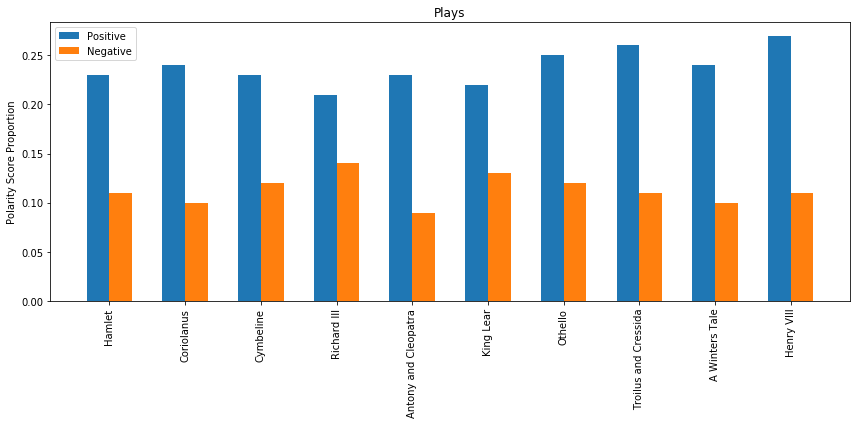

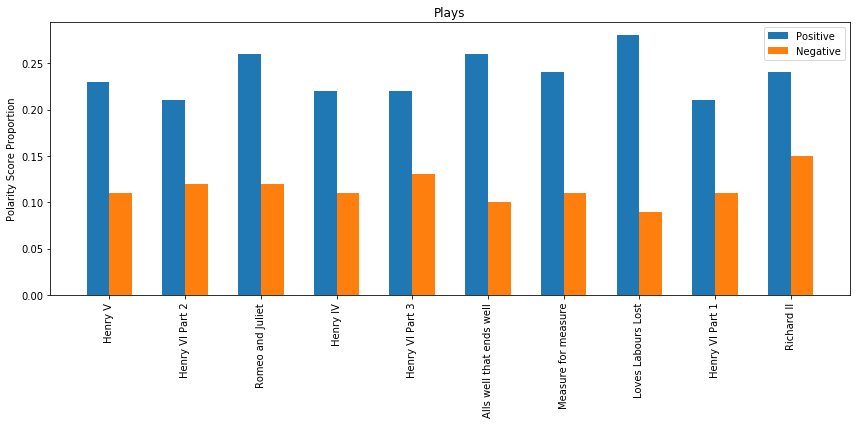

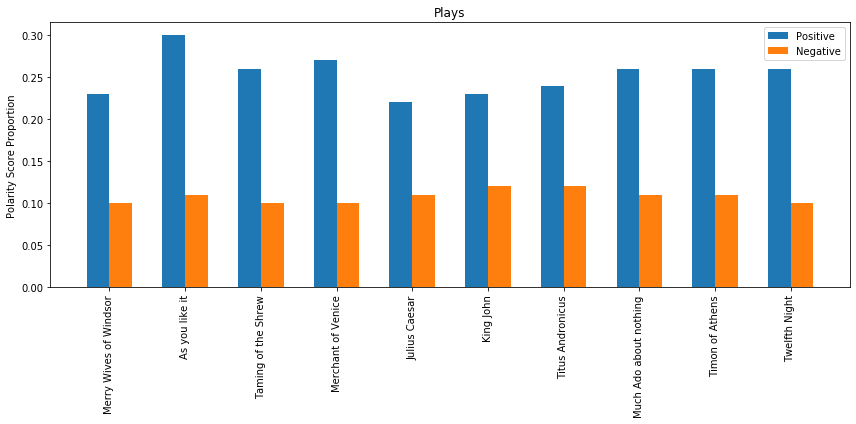

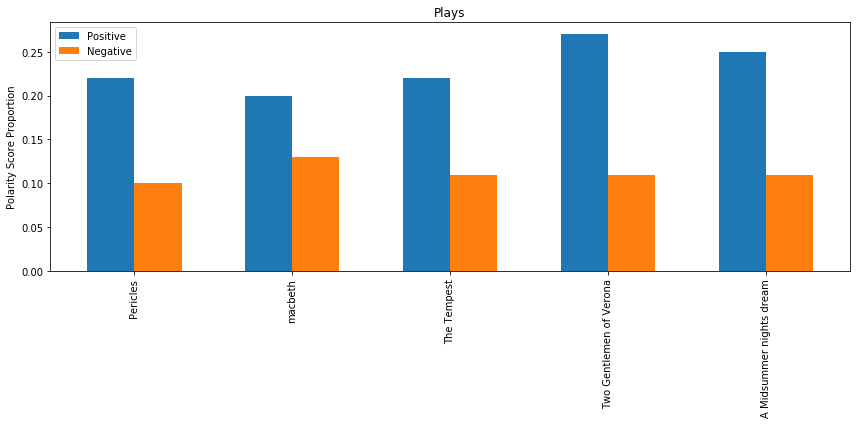

In [11]:
for n in list(np.arange(0, int(len(play_names)/10)*10 +10, 10)):
    j = n+10
    if j> len(play_names):
        j= len(play_names)-1
    else:
        j = n+10 
               
    play_names_ = play_names[n:j]
    neutral_prop_ = neutral_prop[n:j]
    positive_prop_ = positive_prop[n:j]
    negative_prop_ = negative_prop[n:j]
    x = np.arange(len(play_names_))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots(figsize=(12,6))
    # rects1 = ax.bar(x - width/2, neutral_prop, width, label='Neutral')
    rects1 = ax.bar(x - width/2, positive_prop_, width, label='Positive')
    rects2 = ax.bar(x + width/2, negative_prop_, width, label='Negative')

    ax.set_ylabel('Polarity Score Proportion')
    ax.set_title('Plays')
    ax.set_xticks(x)
    ax.set_xticklabels(play_names_)
    ax.legend()

    plt.xticks(rotation=90)
    fig.tight_layout()

    plt.show()

Since the analysis above does not allow us to draw significant conclusions over the sentiment analysis thoughout each plays, we decided to apply the Valder sentiment analysis library to a moving window over each play following the code in the webpage below.

In [12]:
# Source: https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-sentiment-analysis-1b474b13651d

In [13]:
df = pd.read_csv('./shakespeare-plays/Shakespeare_data.csv')

In [14]:
df.head()

Dataline      Play  PlayerLinenumber ActSceneLine         Player  \
0         1  Henry IV               NaN          NaN            NaN   
1         2  Henry IV               NaN          NaN            NaN   
2         3  Henry IV               NaN          NaN            NaN   
3         4  Henry IV               1.0        1.1.1  KING HENRY IV   
4         5  Henry IV               1.0        1.1.2  KING HENRY IV   

                                          PlayerLine  
0                                              ACT I  
1                       SCENE I. London. The palace.  
2  Enter KING HENRY, LORD JOHN OF LANCASTER, the ...  
3             So shaken as we are, so wan with care,  
4         Find we a time for frighted peace to pant,

In [15]:
analyser = SentimentIntensityAnalyzer()
def sentiment_scores(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt['neg'],snt['neu'],snt['pos'],snt['compound']

In [16]:
def list_scores_doc(document):
    doc_plus_sect_scores = []
    for line in document:
        sng,neu,pos,compound = sentiment_scores(line)
        doc_plus_sect_scores.append([line,sng,neu,pos,compound])
    return doc_plus_sect_scores

/Users/marianegri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


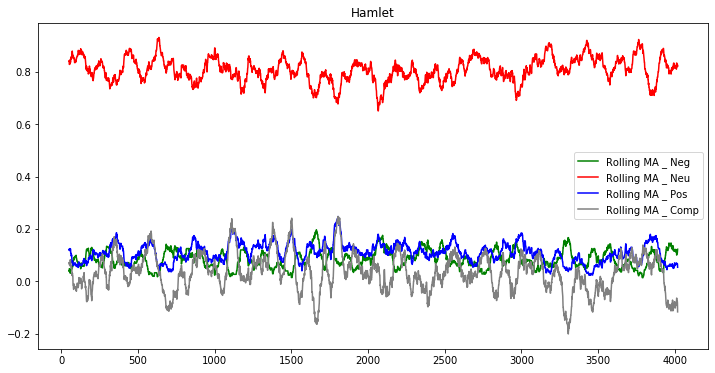

/Users/marianegri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


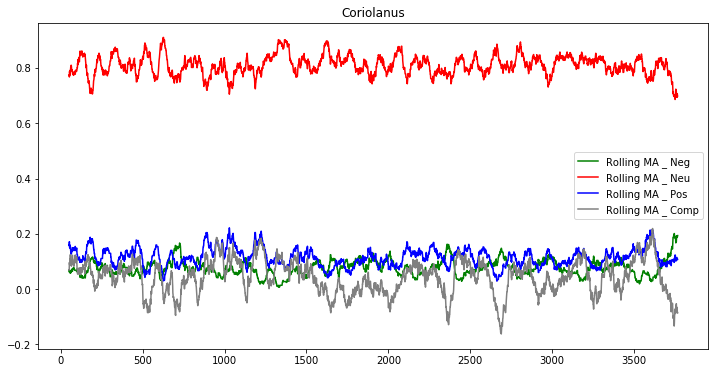

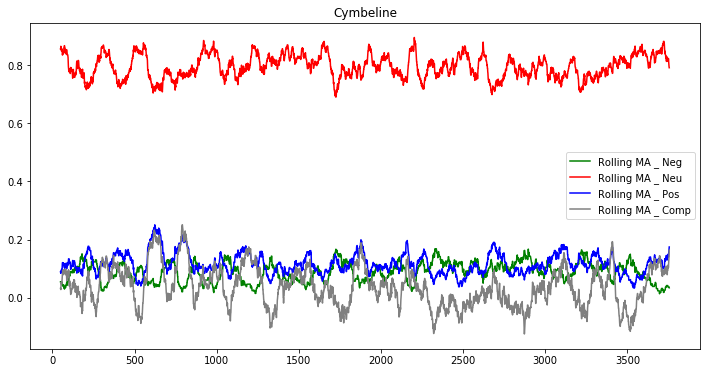

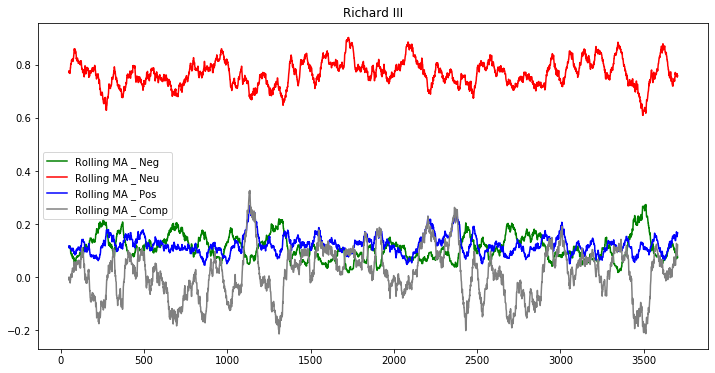

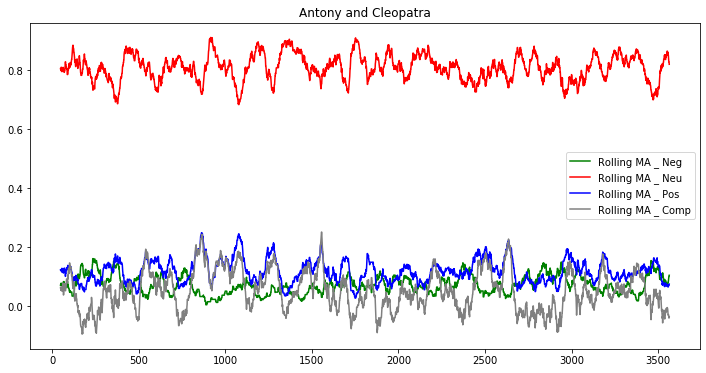

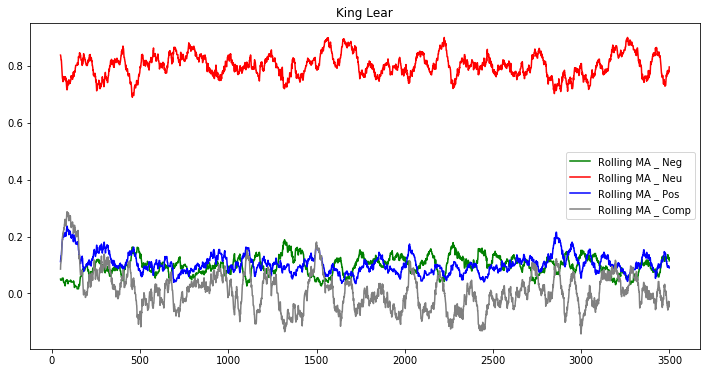

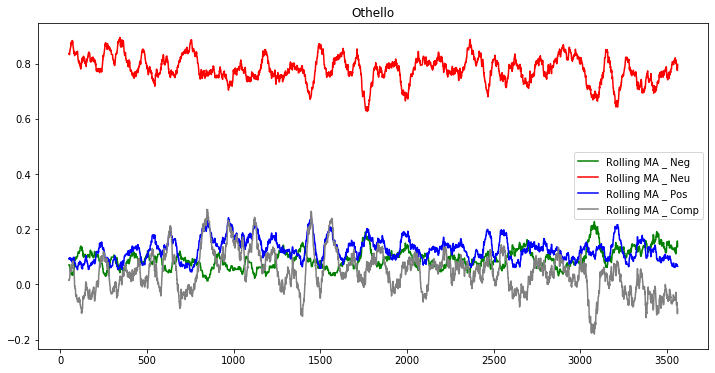

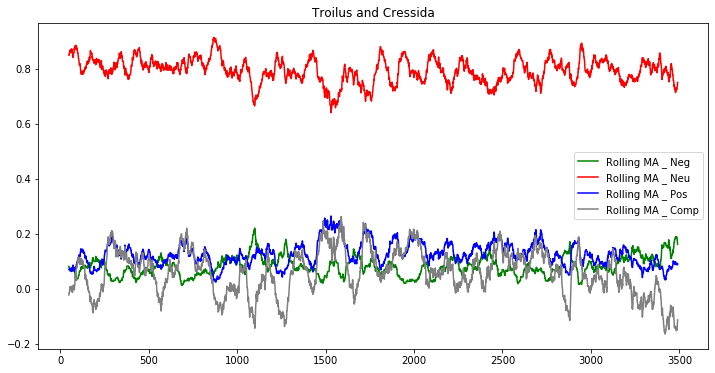

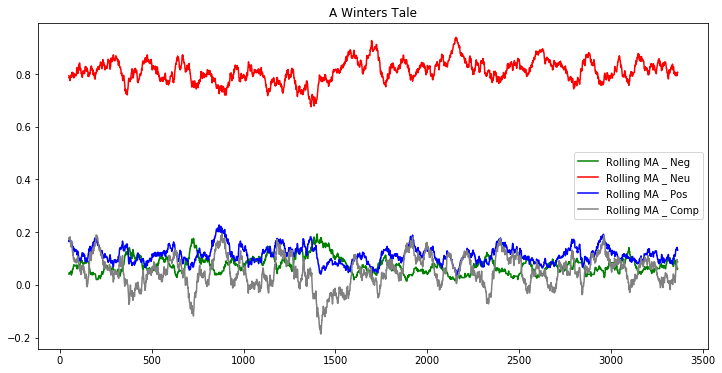

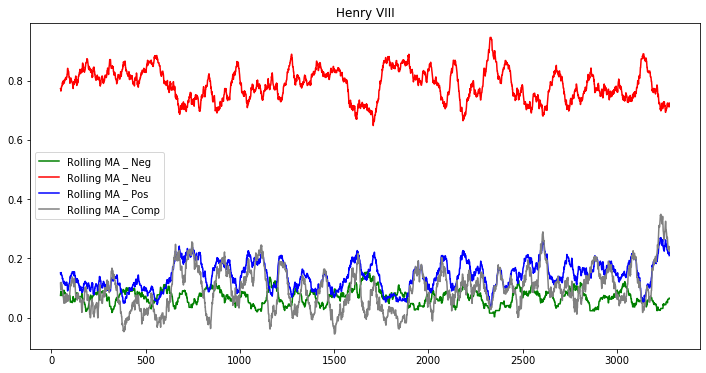

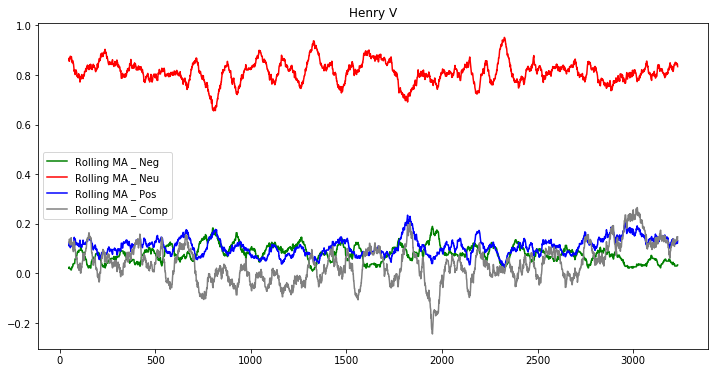

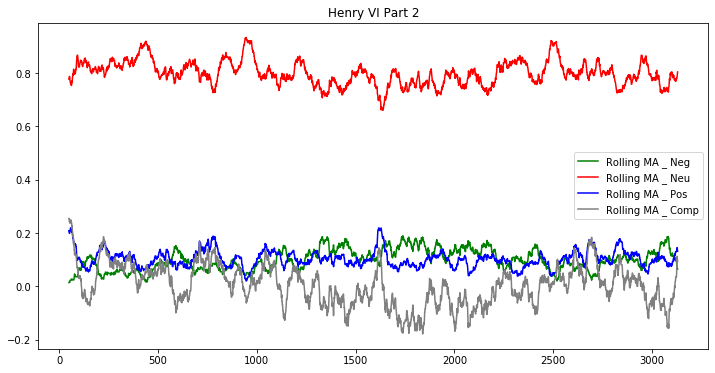

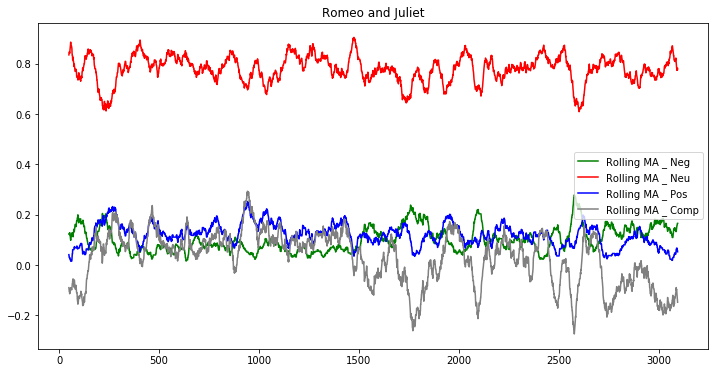

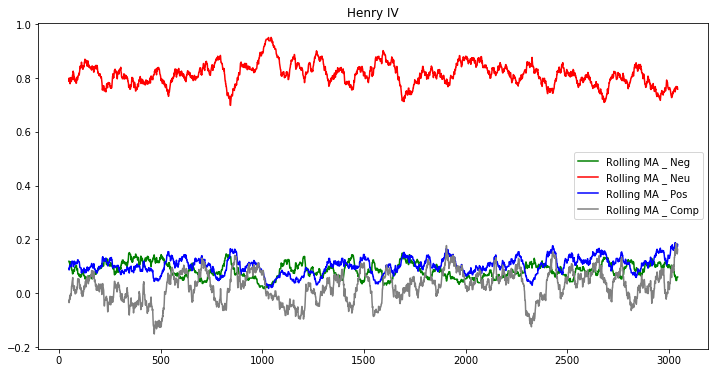

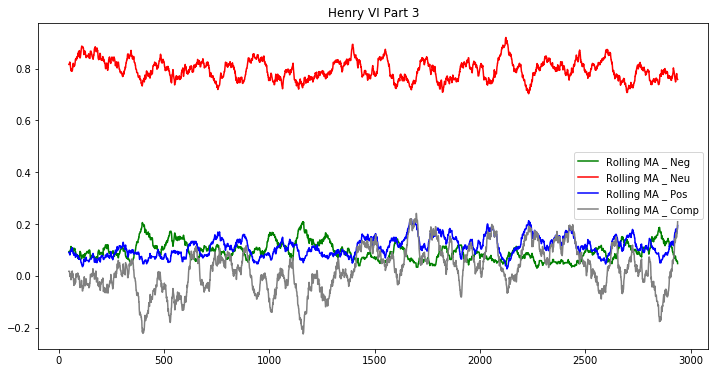

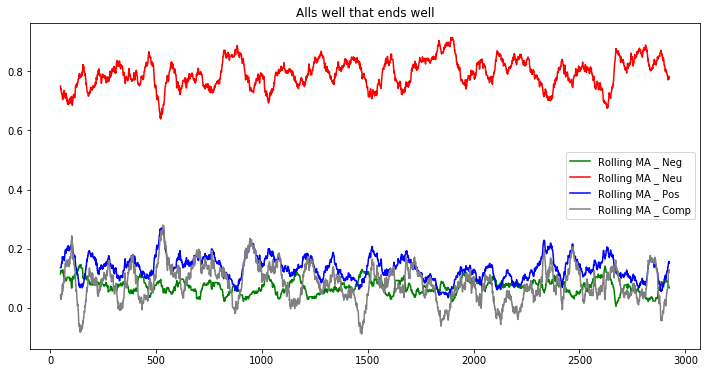

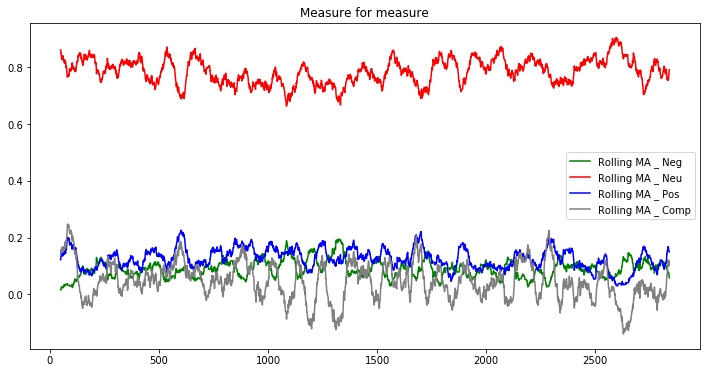

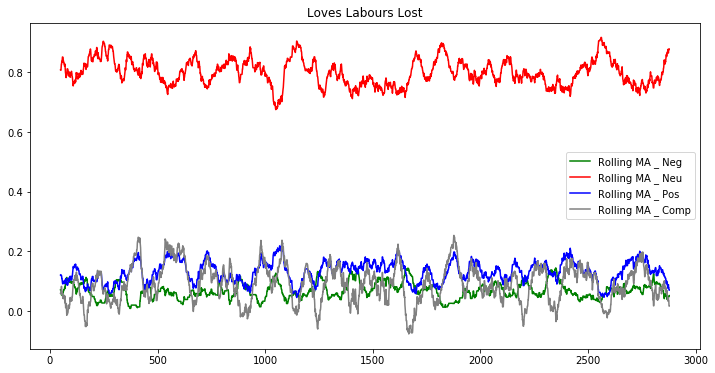

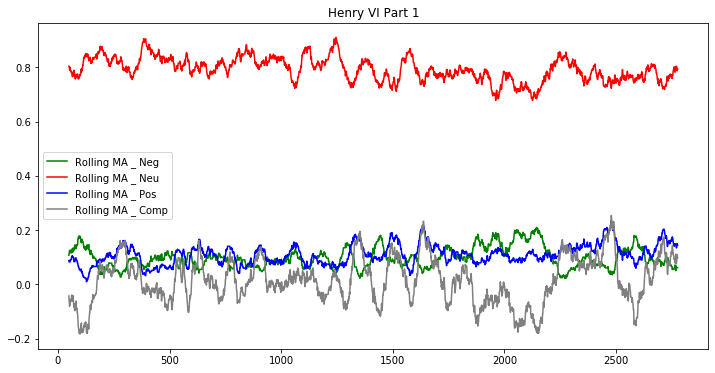

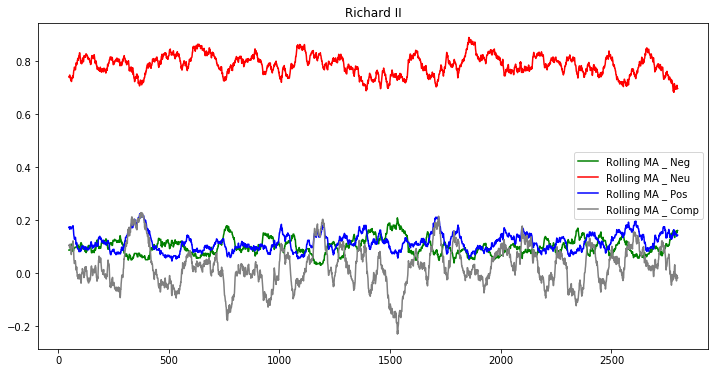

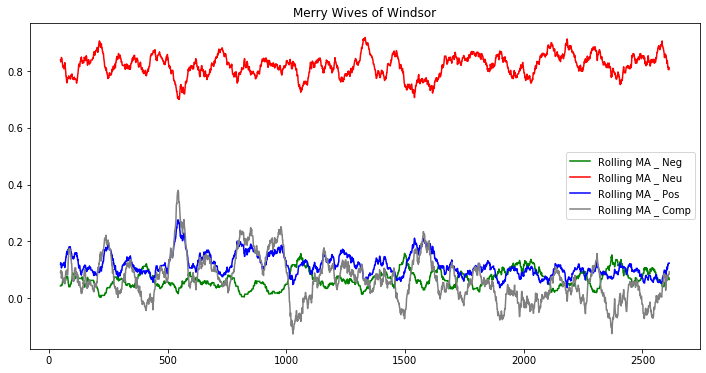

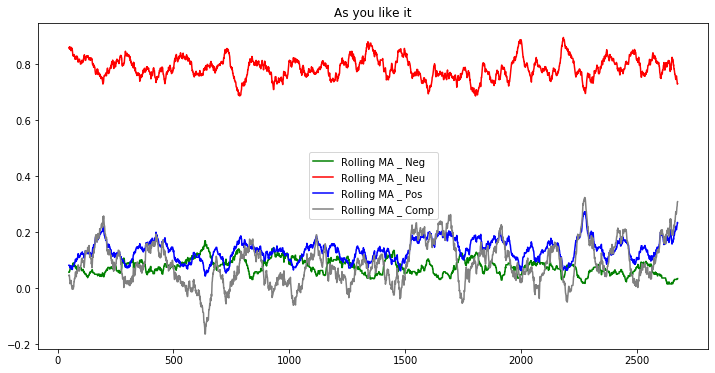

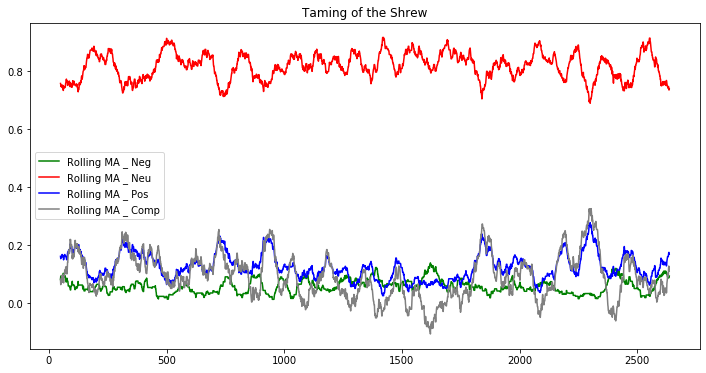

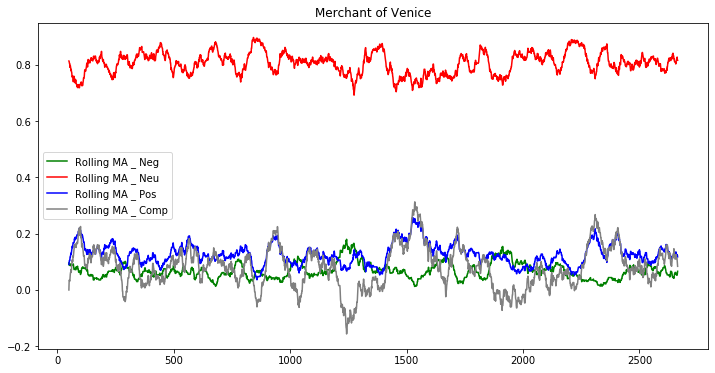

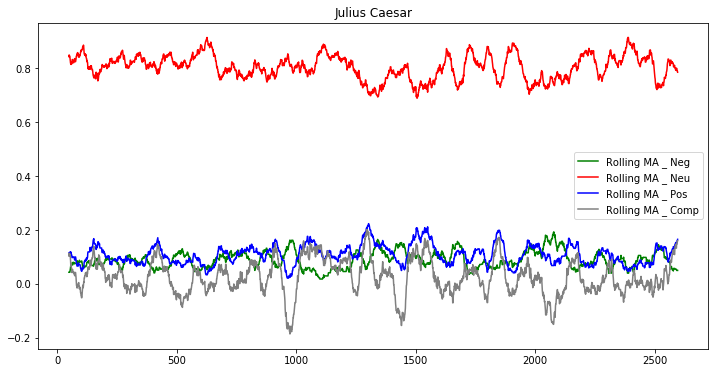

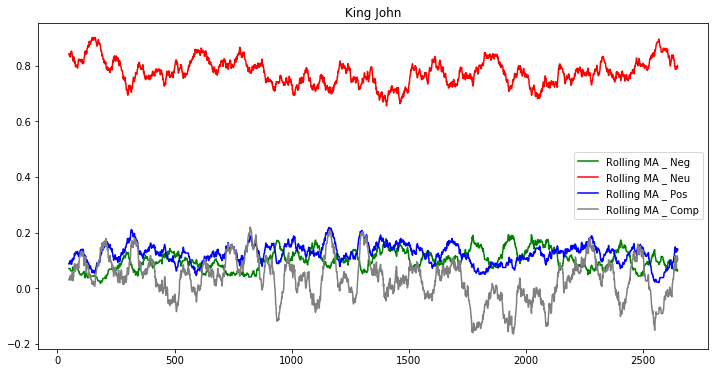

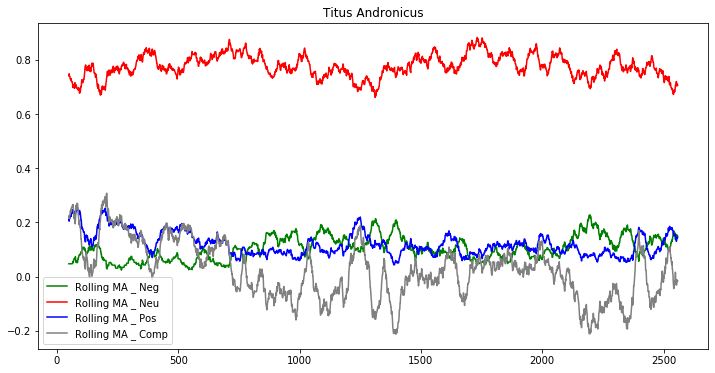

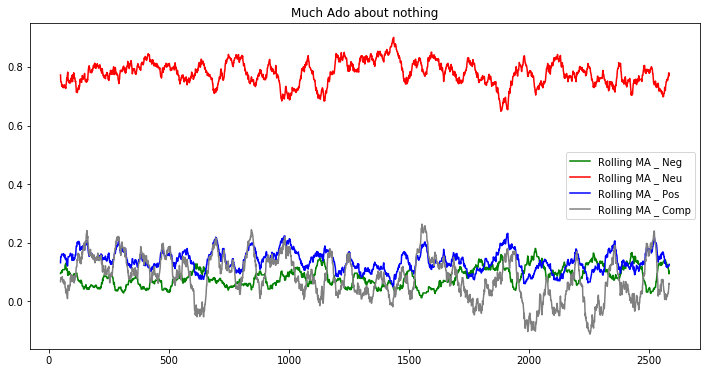

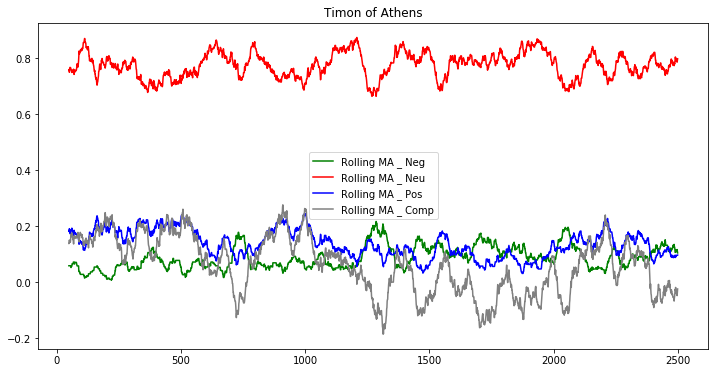

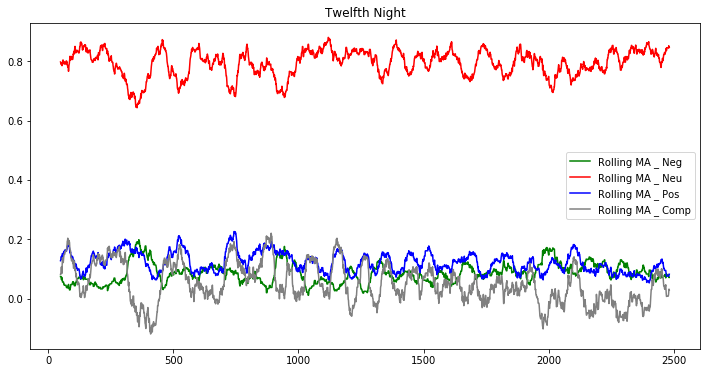

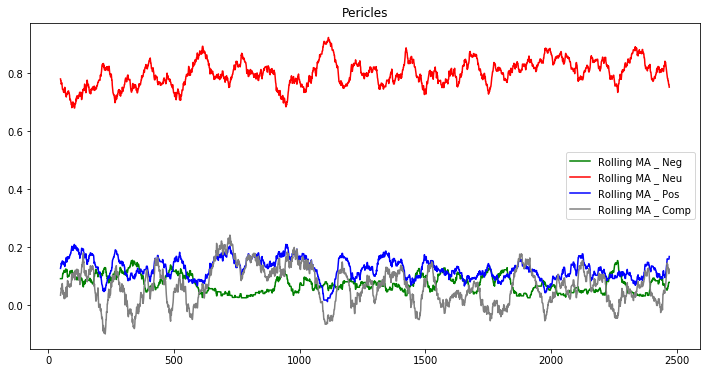

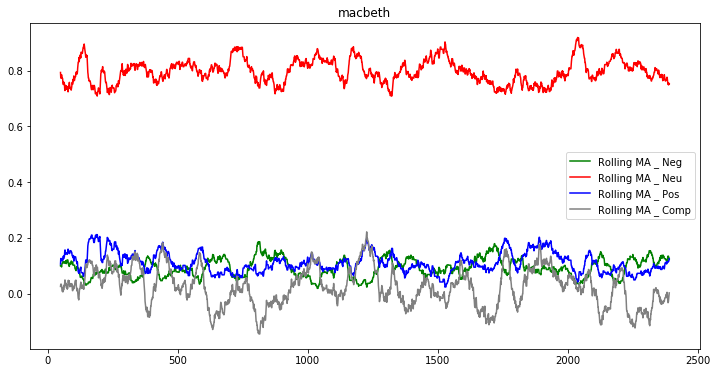

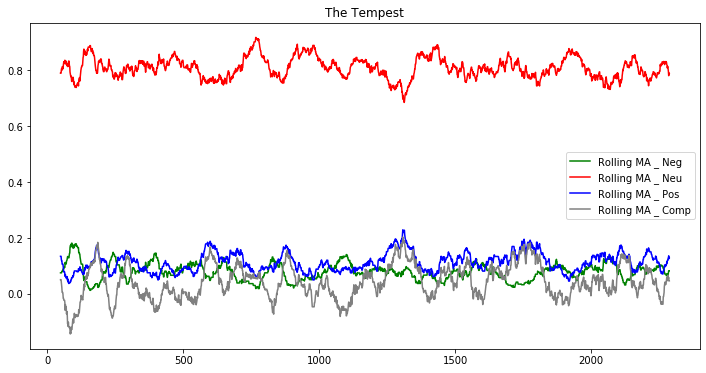

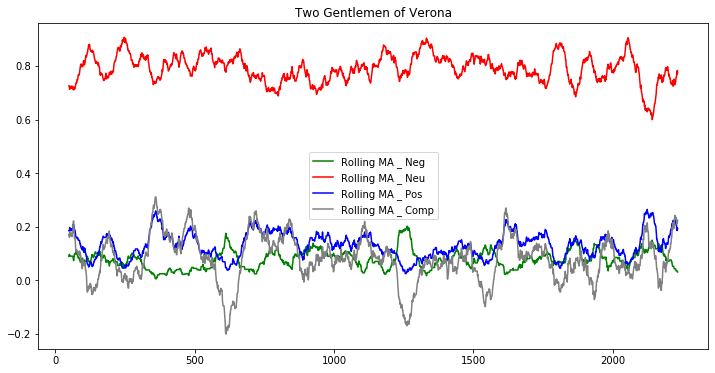

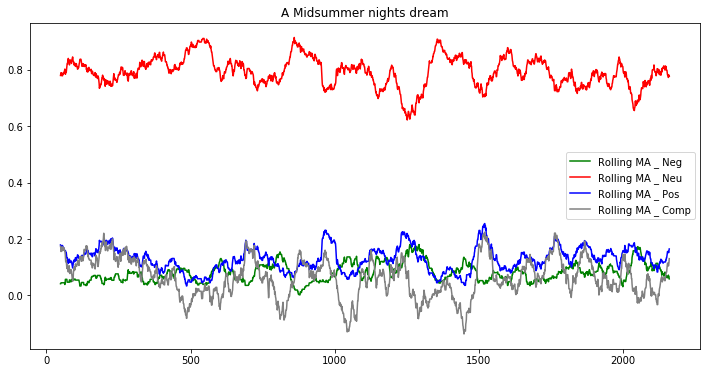

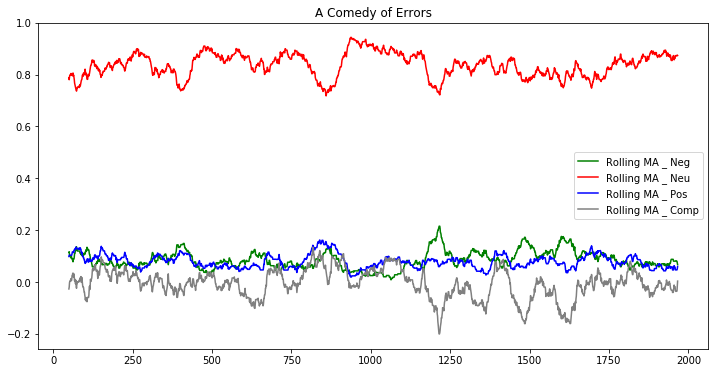

In [17]:
for i in plays_list:
    play_df.dropna(inplace = True)
    play_df = df.loc[(df['Play'] == i)]
    play_df.dropna(inplace = True)

    document = play_df.PlayerLine.values  
    result_list = list_scores_doc(document)
    result_df = pd.DataFrame(result_list,columns = ['Line','Neg','Neu','Pos','Comp'])
    
    result_df['rolling_mean_neg'] = result_df.Neg.rolling(window=50).mean()
    result_df['rolling_mean_neu'] = result_df.Neu.rolling(window=50).mean()
    result_df['rolling_mean_pos'] = result_df.Pos.rolling(window=50).mean()
    result_df['rolling_mean_comp'] = result_df.Comp.rolling(window=50).mean()
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_title(i)

    plt.plot(result_df.index, result_df.rolling_mean_neg, label='Rolling MA _ Neg',color='green')
    plt.plot(result_df.index, result_df.rolling_mean_neu, label='Rolling MA _ Neu',color='red')
    plt.plot(result_df.index, result_df.rolling_mean_pos, label='Rolling MA _ Pos',color='blue')
    plt.plot(result_df.index, result_df.rolling_mean_comp, label='Rolling MA _ Comp',color='grey')
    plt.legend(loc=0)

    plt.show()
    

## Writing style or choice of words used

#### Cosine Similarity

As we can see from the results below, the cosine similarity analysis suggests that the plays show little disparity. This means that this method has not shown evidence that the writing styles differ significantly among the plays. So far, Shakespeare does not seem to be a group of people but just one person.

In [18]:
df = pd.read_csv('./shakespeare-plays/Shakespeare_data.csv')

In [19]:
plays_list = list(df['Play'].value_counts().to_dict().keys())

In [20]:
corpus = []
play_names=[]
for j in plays_list:
    i = j
    play_names.append(i)
    play_df = df.loc[df['Play'] == i]
    play_df = play_df.dropna()
    all_text = play_df.PlayerLine.values
    documents = all_text
    document  = ' '.join(documents)
    corpus.append(document)

In [21]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
print(tfidf_matrix.shape, tfidf_vectorizer.get_feature_names())
tfidf_matrix.toarray()

(36, 22459) ['10', '2d', '2s', '4d', '5s', '6d', '8d', 'aaron', 'abaissiez', 'abandon', 'abandoned', 'abase', 'abash', 'abate', 'abated', 'abatement', 'abatements', 'abates', 'abbess', 'abbey', 'abbeys', 'abbominable', 'abbot', 'abbots', 'abbreviated', 'abed', 'abel', 'abergavenny', 'abet', 'abetting', 'abhominable', 'abhor', 'abhorr', 'abhorred', 'abhorring', 'abhors', 'abhorson', 'abide', 'abides', 'abilities', 'ability', 'abject', 'abjectly', 'abjects', 'abjure', 'abjured', 'able', 'abler', 'aboard', 'abode', 'aboded', 'abodements', 'aboding', 'abominable', 'abominably', 'abominations', 'abortive', 'abortives', 'abound', 'abounding', 'about', 'above', 'abraham', 'abram', 'abreast', 'abridge', 'abridged', 'abridgement', 'abridgment', 'abroach', 'abroad', 'abrogate', 'abrook', 'abrupt', 'abruption', 'abruptly', 'absence', 'absent', 'absey', 'absolute', 'absolutely', 'absolved', 'absolver', 'abstains', 'abstemious', 'abstinence', 'abstract', 'absurd', 'absyrtus', 'abundance', 'abundant

array([[0.       , 0.       , 0.       , ..., 0.0015852, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [22]:
X = pd.DataFrame(tfidf_matrix.toarray(), columns=[ tfidf_vectorizer.get_feature_names()])
X.head()

10   2d   2s   4d   5s   6d   8d aaron abaissiez abandon  ... zenelophon  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   

  zenith   zephyrs  zir   zo zodiac zodiacs      zone    zounds zwaggered  
0    0.0  0.000000  0.0  0.0    0.0     0.0  0.001585  0.000000       0.0  
1    0.0  0.000000  0.0  0.0    0.0     0.0  0.000000  0.000000       0.0  
2    0.0  0.001899  0.0  0.0    0.0     0.0  0.000000  0.000000       0.0  
3    0.0  0.000000  0.0  0.0    0.0     0.0  0.000000  0.004666       0.0  
4    0.0  0.000000  0.0  0.0    0.0     0.0  0.000000  0.000000       0.0  

[5 rows x 22459 columns]

In [23]:
# Compute the norms of each row corresponding to each text
norm_a = np.linalg.norm(tfidf_matrix.toarray()[0,:])
norm_b = np.linalg.norm(tfidf_matrix.toarray()[1,:])
np.dot(tfidf_matrix.toarray()[0,:], tfidf_matrix.toarray()[1,:].T)/(norm_a*norm_b) #cosine similarity

0.9172849171518858

In [24]:
cosine_similarity(tfidf_matrix)

array([[1.        , 0.91728492, 0.94738908, ..., 0.86683561, 0.90114478,
        0.77199734],
       [0.91728492, 1.        , 0.92838232, ..., 0.83611117, 0.8684532 ,
        0.75040876],
       [0.94738908, 0.92838232, 1.        , ..., 0.89201312, 0.90257209,
        0.77905183],
       ...,
       [0.86683561, 0.83611117, 0.89201312, ..., 1.        , 0.84904094,
        0.74938194],
       [0.90114478, 0.8684532 , 0.90257209, ..., 0.84904094, 1.        ,
        0.74744964],
       [0.77199734, 0.75040876, 0.77905183, ..., 0.74938194, 0.74744964,
        1.        ]])

In [25]:
pd.DataFrame(cosine_similarity(tfidf_matrix)) 

0         1         2         3         4         5         6   \
0   1.000000  0.917285  0.947389  0.941194  0.911904  0.946951  0.909744   
1   0.917285  1.000000  0.928382  0.896930  0.901151  0.921006  0.874217   
2   0.947389  0.928382  1.000000  0.940347  0.927964  0.954565  0.912865   
3   0.941194  0.896930  0.940347  1.000000  0.905980  0.945857  0.898202   
4   0.911904  0.901151  0.927964  0.905980  1.000000  0.921142  0.878883   
5   0.946951  0.921006  0.954565  0.945857  0.921142  1.000000  0.910984   
6   0.909744  0.874217  0.912865  0.898202  0.878883  0.910984  1.000000   
7   0.915805  0.891565  0.915905  0.902265  0.887473  0.914460  0.880597   
8   0.948914  0.926355  0.964406  0.938402  0.921225  0.954337  0.916190   
9   0.947060  0.924889  0.947026  0.942510  0.908882  0.945682  0.898864   
10  0.930331  0.898372  0.918714  0.922581  0.888501  0.917235  0.867832   
11  0.922049  0.880576  0.920255  0.946662  0.889011  0.925695  0.870661   
12  0.883310  0.839390  0.894105  0.891198  0.863458  0.893674  0.865077   
13  0.933789  0.895301  0.928970  0.935045  0.897878  0.932742  0.885478   
14  0.888485  0.849462  0.889717  0.930584  0.859602  0.895053  0.843366   
15  0.954023  0.928402  0.960763  0.942462  0.923916  0.957628  0.925744   
16  0.928734  0.915824  0.934368  0.909921  0.897558  0.926910  0.902050   
17  0.923332  0.894351  0.924942  0.906644  0.889211  0.916102  0.876033   
18  0.907109  0.863145  0.908948  0.931355  0.873693  0.911401  0.857102   
19  0.929461  0.879474  0.926171  0.955601  0.893970  0.930613  0.875562   
20  0.882308  0.867843  0.887624  0.864357  0.858266  0.889046  0.868109   
21  0.933733  0.915449  0.939342  0.920754  0.903660  0.940513  0.910254   
22  0.888513  0.861476  0.896212  0.882547  0.861630  0.898204  0.884228   
23  0.935678  0.908613  0.936502  0.923144  0.900901  0.936031  0.899294   
24  0.870764  0.864408  0.874621  0.858285  0.904187  0.868677  0.841565   
25  0.934960  0.892499  0.933586  0.941742  0.898328  0.933998  0.883899   
26  0.887597  0.861849  0.894210  0.903341  0.865198  0.898109  0.859569   
27  0.905991  0.878191  0.911637  0.895086  0.875583  0.906493  0.895224   
28  0.895761  0.871269  0.899111  0.900047  0.872996  0.908715  0.863016   
29  0.926027  0.896248  0.932758  0.913698  0.897990  0.938609  0.909744   
30  0.927165  0.911800  0.941663  0.923234  0.903242  0.933709  0.897613   
31  0.931482  0.912570  0.934838  0.921511  0.906021  0.930503  0.878485   
32  0.927125  0.892502  0.936624  0.929927  0.903650  0.943735  0.894086   
33  0.866836  0.836111  0.892013  0.873597  0.851872  0.883401  0.873238   
34  0.901145  0.868453  0.902572  0.894093  0.871907  0.904472  0.871315   
35  0.771997  0.750409  0.779052  0.775124  0.751917  0.785086  0.759150   

          7         8         9   ...        26        27        28        29  \
0   0.915805  0.948914  0.947060  ...  0.887597  0.905991  0.895761  0.926027   
1   0.891565  0.926355  0.924889  ...  0.861849  0.878191  0.871269  0.896248   
2   0.915905  0.964406  0.947026  ...  0.894210  0.911637  0.899111  0.932758   
3   0.902265  0.938402  0.942510  ...  0.903341  0.895086  0.900047  0.913698   
4   0.887473  0.921225  0.908882  ...  0.865198  0.875583  0.872996  0.897990   
5   0.914460  0.954337  0.945682  ...  0.898109  0.906493  0.908715  0.938609   
6   0.880597  0.916190  0.898864  ...  0.859569  0.895224  0.863016  0.909744   
7   1.000000  0.913319  0.903965  ...  0.862414  0.884962  0.870698  0.900788   
8   0.913319  1.000000  0.950693  ...  0.884814  0.916887  0.895062  0.938111   
9   0.903965  0.950693  1.000000  ...  0.880536  0.897760  0.888149  0.917137   
10  0.896137  0.912105  0.928804  ...  0.875710  0.874935  0.867405  0.883806   
11  0.888144  0.912782  0.927779  ...  0.897401  0.863857  0.880554  0.883265   
12  0.866167  0.888688  0.864556  ...  0.860593  0.869064  0.851469  0.884486   
13  0.906862  0.924819  0.924345  ...  0.889015  0.886564  0.89

We will now carry some clustering methods in order to see if the number of clusters suggests any new evidence about the plays. Before doing that, we will compute PCA projections and work with the for the cluster analysis.

In [26]:
from sklearn import (manifold, datasets, decomposition)
import numpy as np
from numpy import linalg as LA
from sklearn import preprocessing

In [27]:
X_scaled = preprocessing.StandardScaler(with_std=False).fit_transform(X)

In [28]:
eigenvectors, eigenvalues,  v = np.linalg.svd(X_scaled)

In [29]:
eigenvalues

array([7.26681441e-01, 6.03272917e-01, 5.20440188e-01, 4.73099764e-01,
       4.23861194e-01, 4.03060237e-01, 3.82755993e-01, 3.82448453e-01,
       3.49565036e-01, 3.47054446e-01, 3.41087886e-01, 3.30570979e-01,
       3.27488447e-01, 3.14497842e-01, 3.05862310e-01, 2.97067670e-01,
       2.89806329e-01, 2.78834763e-01, 2.77906712e-01, 2.71795398e-01,
       2.65634842e-01, 2.55435293e-01, 2.49973858e-01, 2.44182060e-01,
       2.38984562e-01, 2.33598810e-01, 2.25885326e-01, 2.22159613e-01,
       2.19494936e-01, 2.09216435e-01, 2.05479723e-01, 2.02514711e-01,
       1.88018255e-01, 1.83021898e-01, 1.68825879e-01, 2.10585827e-15])

In [30]:
percent_variance = sum(eigenvalues[0:4]/sum(eigenvalues)*100)
print('The fraction of the variance captured in 2 dimensions is ', str(percent_variance))

The fraction of the variance captured in 2 dimensions is  21.200569897815107


In [31]:
X_pca = decomposition.PCA(n_components=4).fit_transform(X_scaled)
PCA_df = pd.DataFrame(X_pca,columns =['PC1','PC2','PC3','PC4']).join(pd.DataFrame(plays_list,columns = ['Play']))

In [32]:
PCA_df.sort_values(by=['PC2'], ascending=False).head()

PC1       PC2       PC3       PC4                Play
35  0.231700  0.526086 -0.161098 -0.041585  A Comedy of Errors
14 -0.226866  0.106794  0.098518  0.026424     Henry VI Part 3
26 -0.100087  0.077614  0.110616  0.122633    Titus Andronicus
11 -0.207197  0.057771  0.030359 -0.022076     Henry VI Part 2
18 -0.212540  0.055095  0.041561 -0.027854     Henry VI Part 1

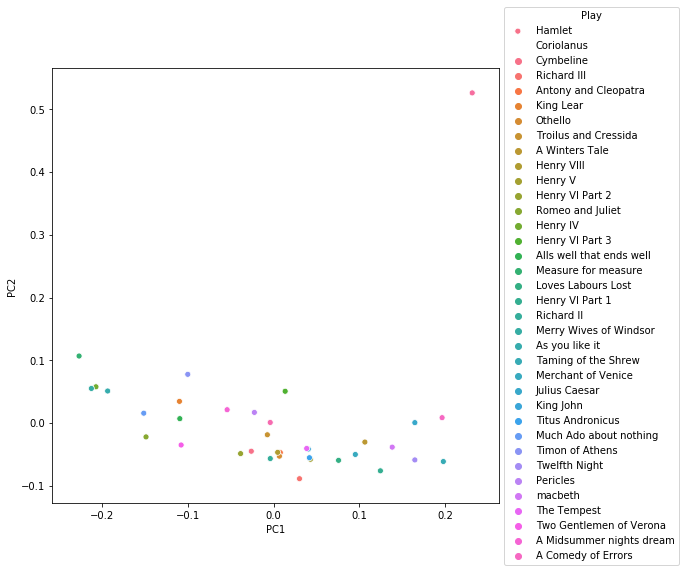

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(x="PC1", y="PC2", hue="Play",data= PCA_df)
ax.legend(PCA_df.Play,
          title="Play",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

In [34]:
PCA_df.sort_values(by=['PC4'], ascending=False).head()

PC1       PC2       PC3       PC4                  Play
24  0.041820 -0.055272 -0.173109  0.347493         Julius Caesar
4   0.006807 -0.052786 -0.110104  0.167461  Antony and Cleopatra
26 -0.100087  0.077614  0.110616  0.122633      Titus Andronicus
12  0.013519  0.050633  0.183249  0.081074      Romeo and Juliet
28 -0.022407  0.016954  0.018923  0.071574       Timon of Athens

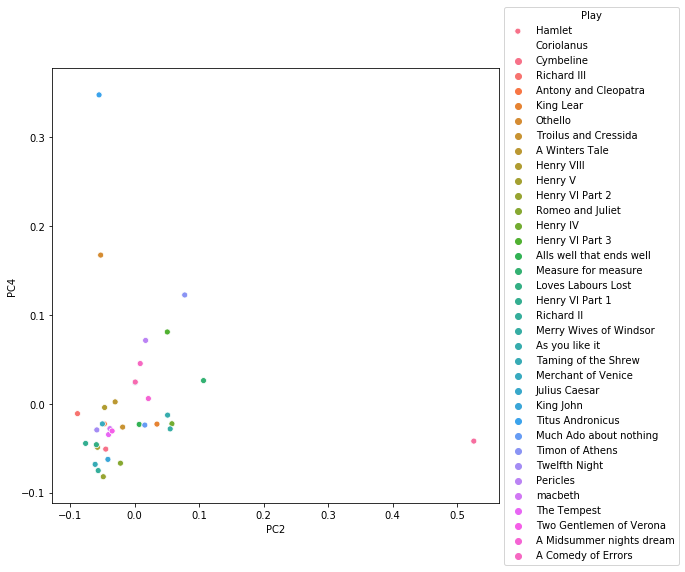

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.scatterplot(x="PC2", y="PC4", hue="Play",data= PCA_df)
ax.legend(PCA_df.Play,
          title="Play",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

From the analysis above, PCA analysis shows some outliers:
- A Comedy of Errors
- Julius Caesar
- Antony and Cleopatra
- Titus Andronicus

In [36]:
X = PCA_df[['PC1','PC2']]
X.head()

PC1       PC2
0 -0.025997 -0.044910
1  0.030237 -0.088709
2  0.007839 -0.047084
3 -0.109786  0.034548
4  0.006807 -0.052786

In [37]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, random_state=0).fit(X)
    classes = kmeans.predict(X)
    print(round(silhouette_score(X, classes, metric='euclidean'),2))

0.48
0.53
0.5
0.49
0.43


In [38]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 2], dtype=int32)

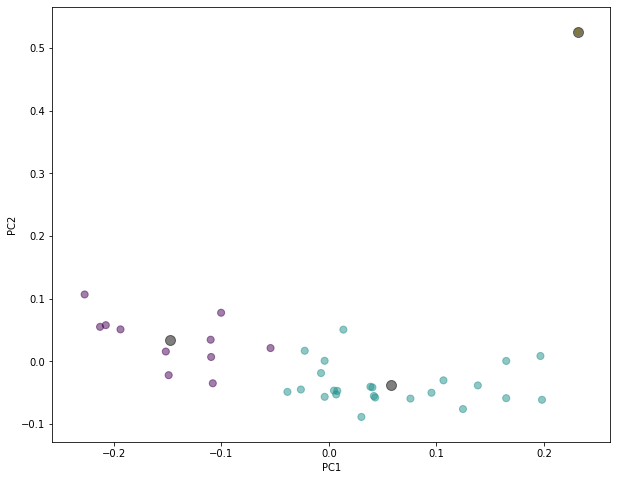

In [39]:
plt.figure(figsize=(10,8))
plt.scatter(X['PC1'], X['PC2'], c=y_kmeans, s=50, cmap='viridis', alpha=0.5)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
plt.xlabel('PC1')
plt.ylabel('PC2');

For n_clusters = 2 The average silhouette_score is : 0.4759828603959238


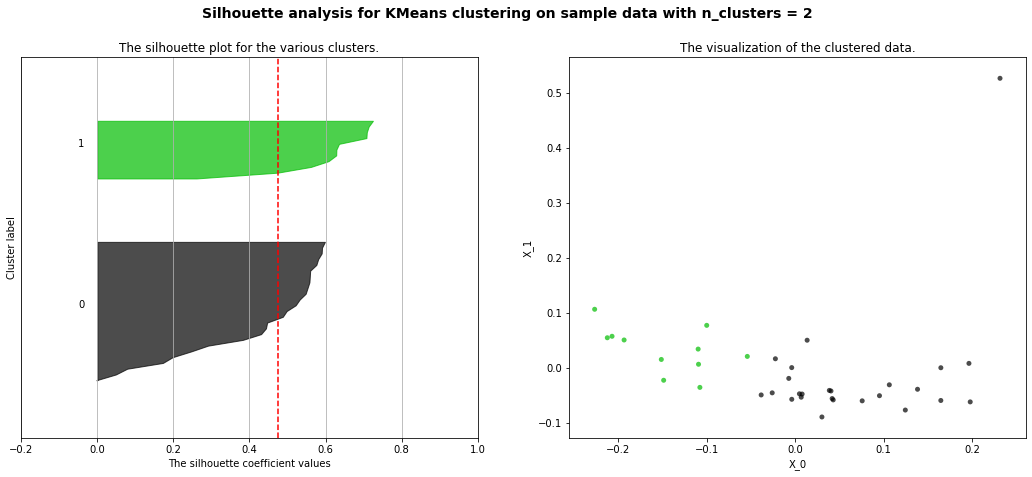

For n_clusters = 3 The average silhouette_score is : 0.532306295059589


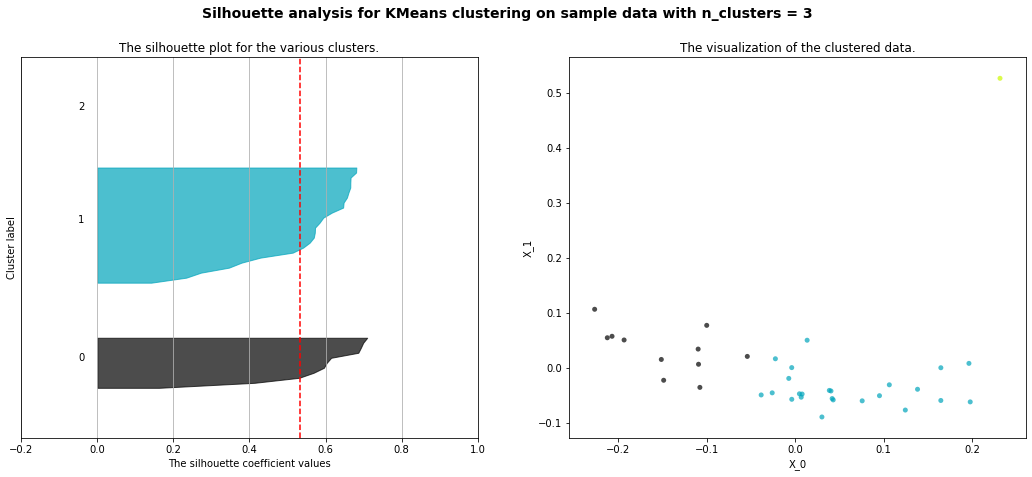

For n_clusters = 4 The average silhouette_score is : 0.5024381326019038


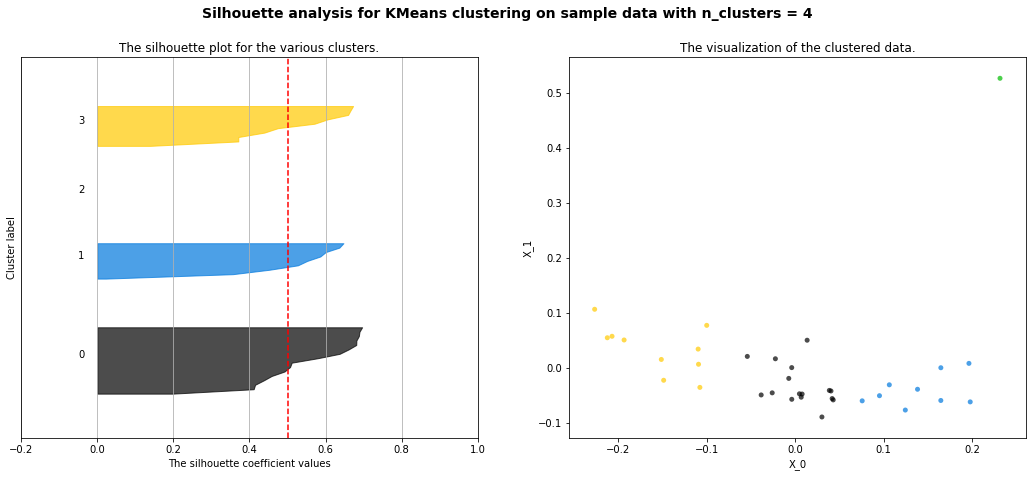

For n_clusters = 5 The average silhouette_score is : 0.4867582354259542


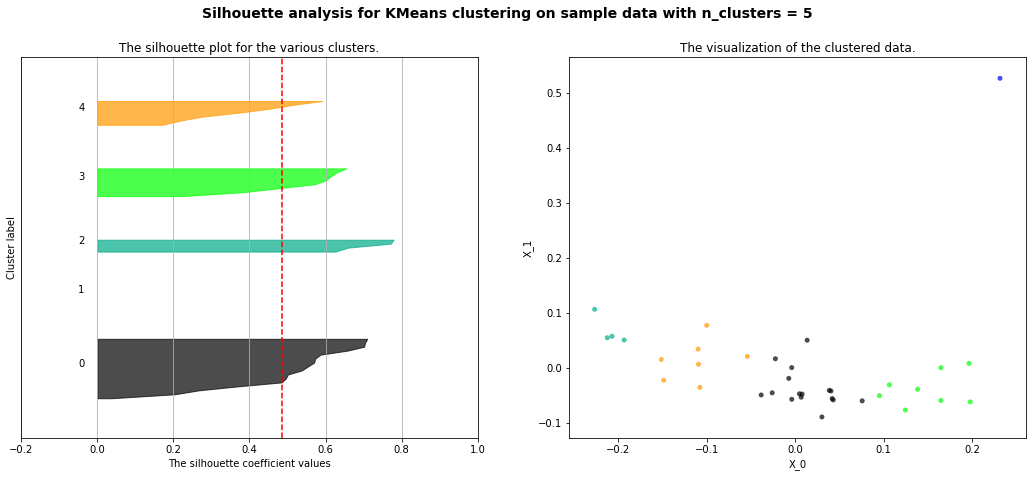

For n_clusters = 6 The average silhouette_score is : 0.43002356358767757


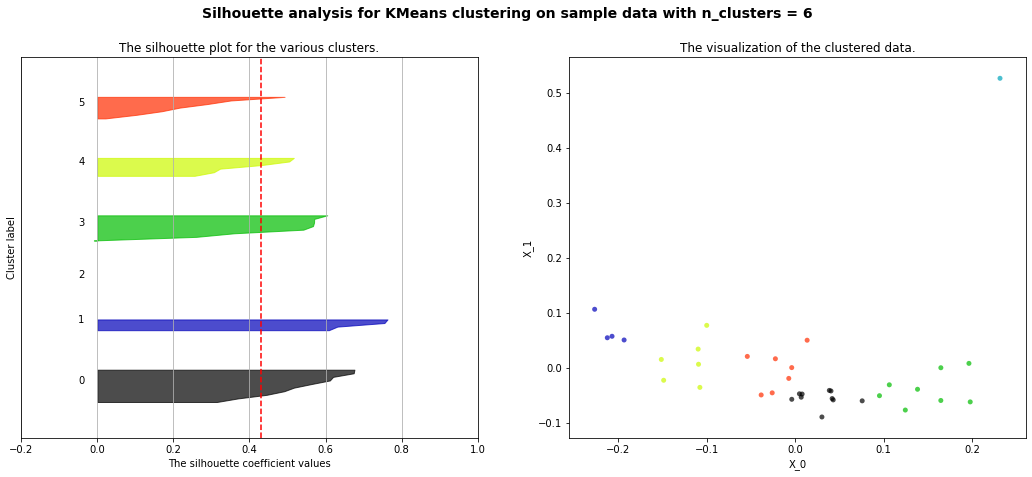

In [40]:
# Taken from the SciKit Learn website examples
# Plots the solhouette scores to check the selection of clusters
def make_silhouette(X_in):
    range_n_clusters = [2, 3, 4, 5, 6]
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X_in) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X_in)

        silhouette_avg = silhouette_score(X_in, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_in, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.xaxis.grid(True)
        ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Draw white circles at cluster centers
        centers = clusterer.cluster_centers_
        
        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        
        ax2.scatter(X_in['PC1'], X_in['PC2'], marker='.', s=100, lw=0, alpha=0.7, c=colors)
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel('X_0')
        ax2.set_ylabel('X_1')
        ax2.grid(False)

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        #remove_border()
        plt.show()
        
# run the silhouette plotting function
make_silhouette(X)

#### Hierarchical Clustering

Source: Section 7

In [41]:
PCA_df.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'Play'], dtype='object')

In [42]:
ncilabs = PCA_df.Play
ncidata = PCA_df[['PC1', 'PC2', 'PC3', 'PC4']]
print(ncilabs.shape, ncidata.shape)

(36,) (36, 4)


In [43]:
# #Scaling
# std_scale = StandardScaler().fit(ncidata[ncidata.columns])
# ncidata[ncidata.columns] = std_scale.transform(ncidata[ncidata.columns])

In [44]:
ncilabs.head()

0                  Hamlet
1              Coriolanus
2               Cymbeline
3             Richard III
4    Antony and Cleopatra
Name: Play, dtype: object

In [45]:
ncidata.head()

PC1       PC2       PC3       PC4
0 -0.025997 -0.044910 -0.046079 -0.050574
1  0.030237 -0.088709 -0.163317 -0.010725
2  0.007839 -0.047084 -0.022219 -0.022262
3 -0.109786  0.034548  0.044307 -0.022477
4  0.006807 -0.052786 -0.110104  0.167461

In [46]:
Z = linkage(ncidata, 'average')

In [47]:
c, coph_dists = cophenet(Z, pdist(ncidata))
c

0.8743258116968957

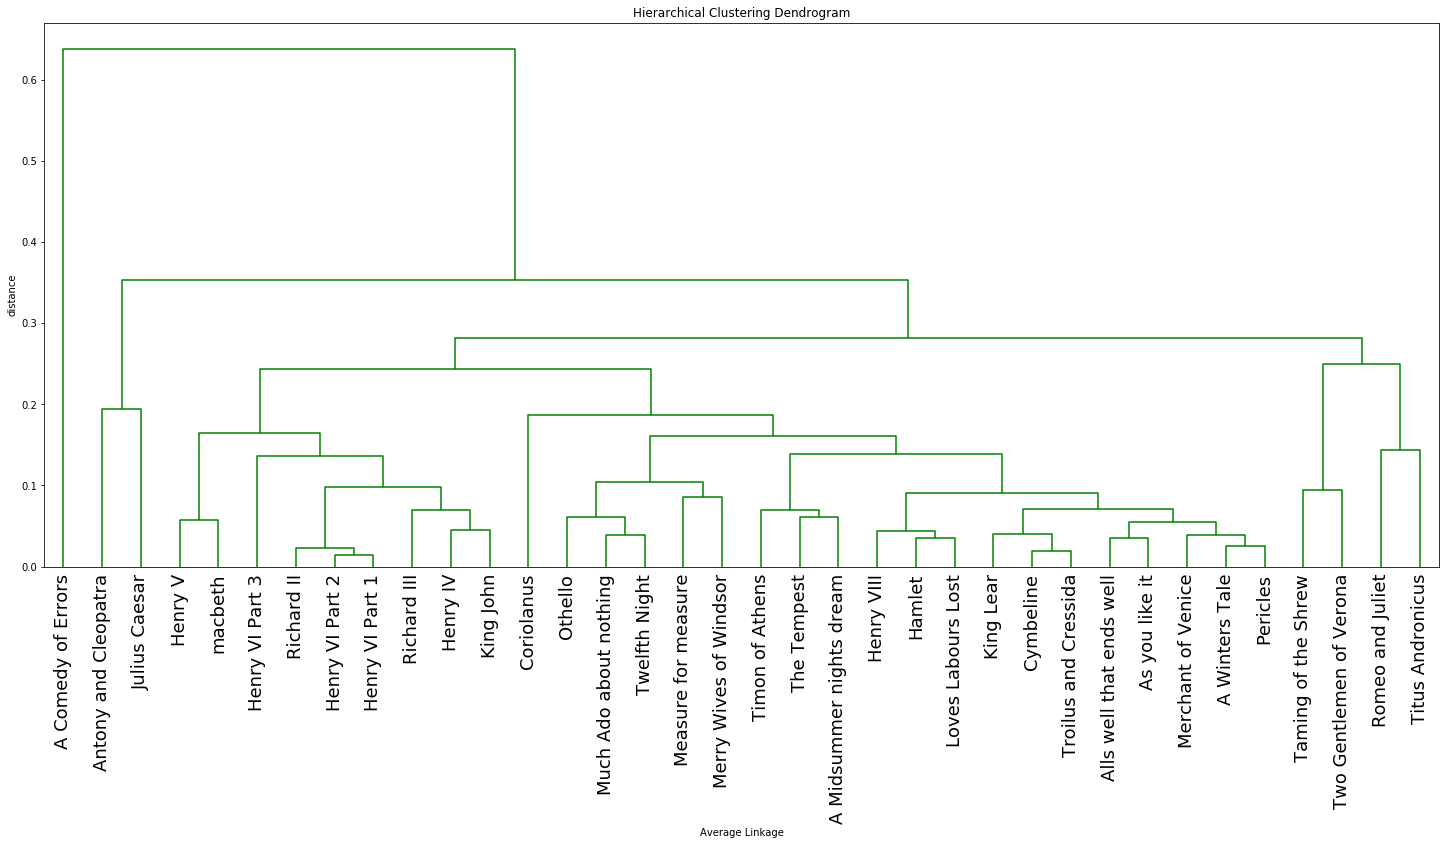

In [48]:
ncidata['ncilabs']=ncilabs  ##Labels for x axis
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Average Linkage')
plt.ylabel('distance')
dend = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels= np.array(ncidata.ncilabs), #Labels for x axis
    color_threshold = 125, #np.inf, #What's 125 ? It is dist. on y axis, cutting the dendrogram horizontally giving 3 clusters 
    #p=64
)
plt.axhline(y=125, c='k' , linestyle='--')  # Notice the 3 clusters
plt.show() #Output is similar to given in ISLR Book
#list(dend.items())[2][1][1:]

In [49]:
cutree = cut_tree(Z, n_clusters=[3]).flatten()
cutree

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2])

In [50]:
#Getting labels for each of the clusters
nclusters=3
for i in range(nclusters):
    c1 = np.argwhere(cutree==i).flatten()
    print("\nCluster: ",i," ",list(ncilabs[c1])) 
    print(c1)


Cluster:  0   ['Hamlet', 'Coriolanus', 'Cymbeline', 'Richard III', 'King Lear', 'Othello', 'Troilus and Cressida', 'A Winters Tale', 'Henry VIII', 'Henry V', 'Henry VI Part 2', 'Romeo and Juliet', 'Henry IV', 'Henry VI Part 3', 'Alls well that ends well', 'Measure for measure', 'Loves Labours Lost', 'Henry VI Part 1', 'Richard II', 'Merry Wives of Windsor', 'As you like it', 'Taming of the Shrew', 'Merchant of Venice', 'King John', 'Titus Andronicus', 'Much Ado about nothing', 'Timon of Athens', 'Twelfth Night', 'Pericles', 'macbeth', 'The Tempest', 'Two Gentlemen of Verona', 'A Midsummer nights dream']
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34]

Cluster:  1   ['Antony and Cleopatra', 'Julius Caesar']
[ 4 24]

Cluster:  2   ['A Comedy of Errors']
[35]


Both clustering techniques show similar results. We will explore further into these three cluserts and see if there is any writing patten relevant in each of them. 

Clustering analysis suggests there are at least two or three writing styles. The play 'A Comedy of Errors' seems to be an oullier. We will now run K-means again and see if there results change any further.  

#### Working without outliers: K Means

In [51]:
X = pd.DataFrame(tfidf_matrix.toarray(), columns=[ tfidf_vectorizer.get_feature_names()])
X.head()

10   2d   2s   4d   5s   6d   8d aaron abaissiez abandon  ... zenelophon  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0       0.0     0.0  ...        0.0   

  zenith   zephyrs  zir   zo zodiac zodiacs      zone    zounds zwaggered  
0    0.0  0.000000  0.0  0.0    0.0     0.0  0.001585  0.000000       0.0  
1    0.0  0.000000  0.0  0.0    0.0     0.0  0.000000  0.000000       0.0  
2    0.0  0.001899  0.0  0.0    0.0     0.0  0.000000  0.000000       0.0  
3    0.0  0.000000  0.0  0.0    0.0     0.0  0.000000  0.004666       0.0  
4    0.0  0.000000  0.0  0.0    0.0     0.0  0.000000  0.000000       0.0  

[5 rows x 22459 columns]

In [52]:
X_scaled = preprocessing.StandardScaler(with_std=False).fit_transform(X)

In [53]:
X_scaled.shape

(36, 22459)

In [54]:
Z = pd.DataFrame(X_scaled).join(pd.DataFrame(plays_list,columns = ['Play']))

In [55]:
Z.columns

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
        22450,  22451,  22452,  22453,  22454,  22455,  22456,  22457,  22458,
       'Play'],
      dtype='object', length=22460)

In [56]:
Z.set_index('Play',inplace = True)

In [57]:
Z_noCofE = Z.drop(index='A Comedy of Errors')

In [58]:
Z_noCofE.head()

0         1         2         3         4      \
Play                                                                     
Hamlet               -0.000057 -0.000056 -0.000113 -0.000056 -0.000056   
Coriolanus           -0.000057 -0.000056 -0.000113 -0.000056 -0.000056   
Cymbeline            -0.000057 -0.000056 -0.000113 -0.000056 -0.000056   
Richard III          -0.000057 -0.000056 -0.000113 -0.000056 -0.000056   
Antony and Cleopatra -0.000057 -0.000056 -0.000113 -0.000056 -0.000056   

                         5         6         7        8         9      ...  \
Play                                                                   ...   
Hamlet               -0.000056 -0.000056 -0.001867 -0.00005 -0.000405  ...   
Coriolanus           -0.000056 -0.000056 -0.001867 -0.00005 -0.000405  ...   
Cymbeline            -0.000056 -0.000056 -0.001867 -0.00005 -0.000405  ...   
Richard III          -0.000056 -0.000056 -0.001867 -0.00005 -0.000405  ...   
Antony and Cleopatra -0.000056 -0.000056 -0.001867 -0.00005 -0.000405  ...   

                         22449     22450     22451     22452     22453  \
Play                                                                     
Hamlet               -0.000064 -0.000089 -0.000053 -0.000112 -0.000056   
Coriolanus           -0.000064 -0.000089 -0.000053 -0.000112 -0.000056   
Cymbeline            -0.000064 -0.000089  0.001846 -0.000112 -0.000056   
Richard III          -0.000064 -0.000089 -0.000053 -0.000112 -0.000056   
Antony and Cleopatra -0.000064 -0.000089 -0.000053 -0.000112 -0.000056   

                         22454     22455     22456     22457     22458  
Play                                                                    
Hamlet               -0.000067 -0.000061  0.001541 -0.000788 -0.000056  
Coriolanus           -0.000067 -0.000061 -0.000044 -0.000788 -0.000056  
Cymbeline            -0.000067 -0.000061 -0.000044 -0.000788 -0.000056  
Richard III          -0.000067 -0.000061 -0.000044  0.003877 -0.000056  
Antony and Cleopatra -0.000067 -0.000061 -0.000044 -0.000788 -0.000056  

[5 rows x 22459 columns]

In [59]:
Z_noCofE_scaled = preprocessing.StandardScaler(with_std=False).fit_transform(Z_noCofE)

In [60]:
import sklearn
from sklearn.decomposition import PCA

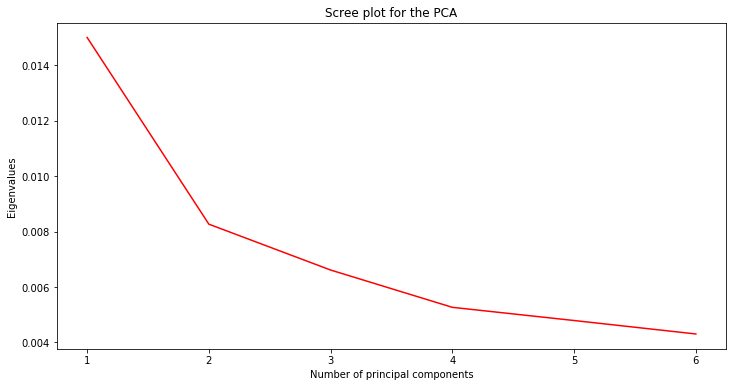

The 1st Principal Component explains 14.3 % of the variance

The 1st and 2nd Principal Components explain 22.2 % of the variance

The 1st, 2nd and 3rd Principal Components explain 28.5 % of the variance

The first four Principal Components explain 33.5 % of the variance

The first five Principal Components explain 38.1 % of the variance

The first six Principal Components explain 42.2 % of the variance



In [61]:
Z_noCofE_pca = sklearn.decomposition.PCA(n_components=6).fit(Z_noCofE_scaled)
plt.figure(figsize=(12, 6))
eig = Z_noCofE_pca.explained_variance_
var_exp = Z_noCofE_pca.explained_variance_ratio_.cumsum()*100.
plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))
print ('The first four Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[3]))
print ('The first five Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[4]))
print ('The first six Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[5]))

In [62]:
Z_noCofE_pca = decomposition.PCA(n_components=2).fit_transform(Z_noCofE_scaled)

In [63]:
Z_noCofE_pca_df = pd.DataFrame(Z_noCofE_pca,columns =['PC1','PC2'])

For n_clusters = 2 The average silhouette_score is : 0.4107885048594093


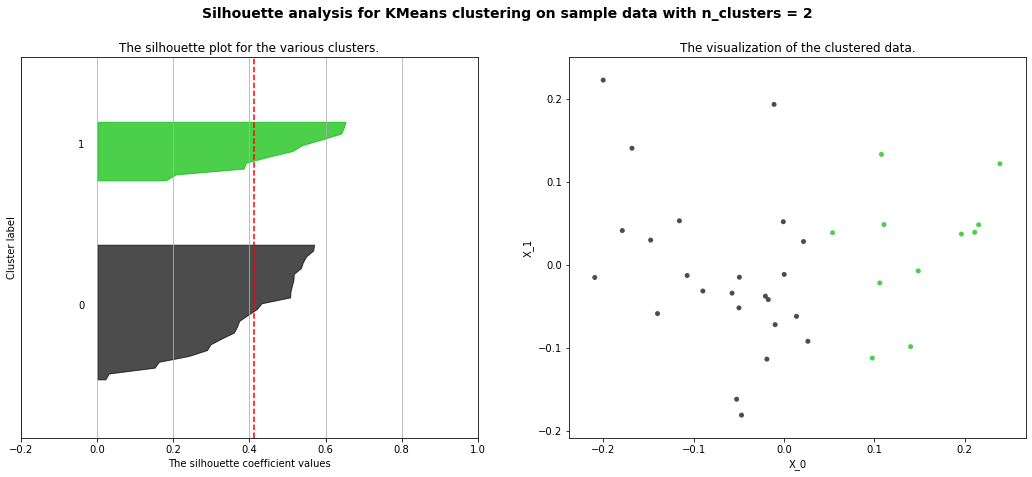

For n_clusters = 3 The average silhouette_score is : 0.414071382995161


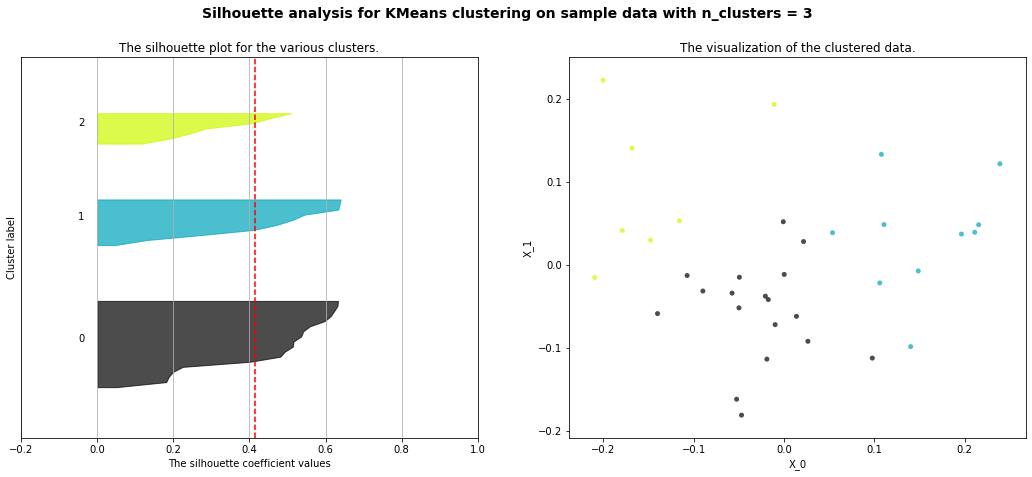

For n_clusters = 4 The average silhouette_score is : 0.38203313774687575


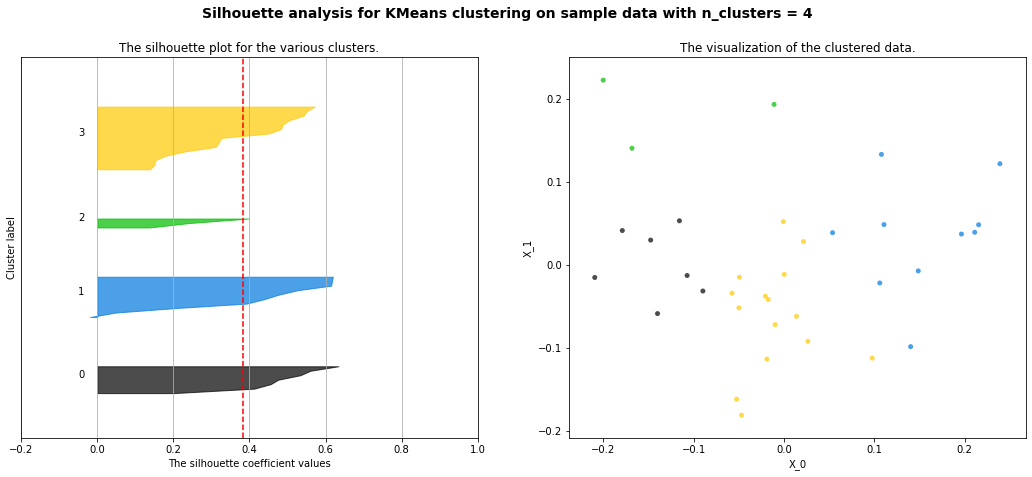

For n_clusters = 5 The average silhouette_score is : 0.3780804686278634


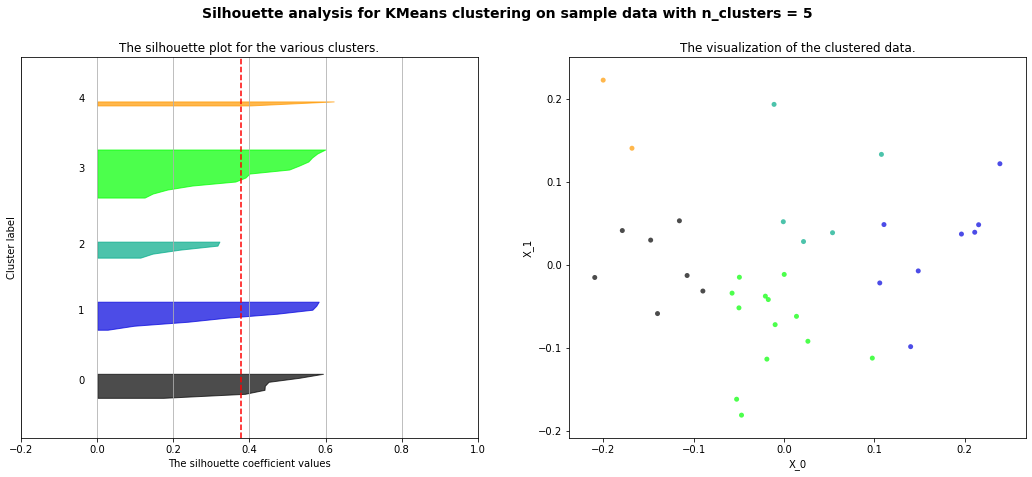

For n_clusters = 6 The average silhouette_score is : 0.37542307495556365


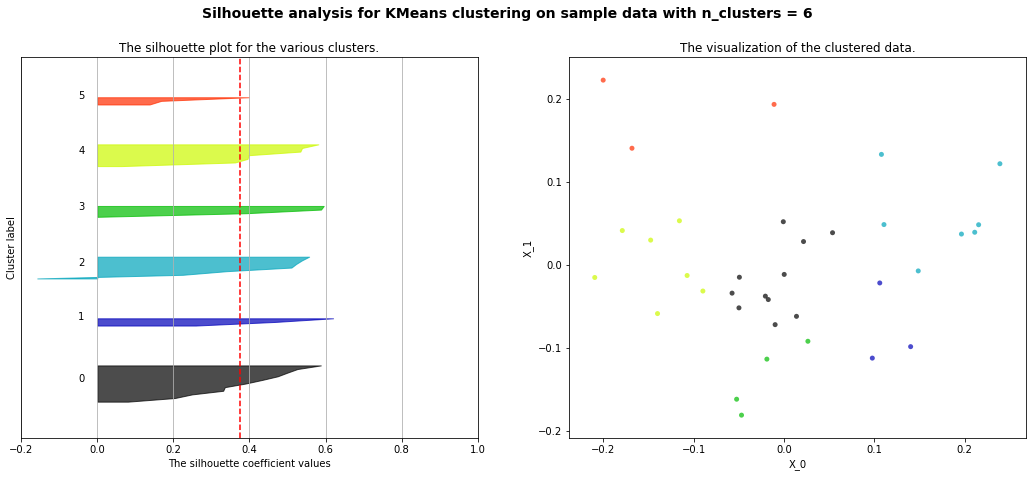

In [64]:
# Run the silhouette plotting function
make_silhouette(Z_noCofE_pca_df)

Kmeans analysis continues to indicate that there are two clusters. Considering that there is an outlier, we would be working with three groups in this case

#### Working without outliers: Hierarchical Clustering

In [65]:
Z_noCofE_pca_df.head()

PC1       PC2
0  0.013902 -0.061807
1 -0.046919 -0.180707
2 -0.020524 -0.037519
3  0.110709  0.048630
4 -0.018858 -0.113297

In [66]:
ncilabs = Z_noCofE.index
ncidata = Z_noCofE_pca_df
print(ncilabs.shape, ncidata.shape)

(35,) (35, 2)


In [67]:
Z = linkage(ncidata, 'average')

In [68]:
c, coph_dists = cophenet(Z, pdist(ncidata))
c

0.7012026823680488

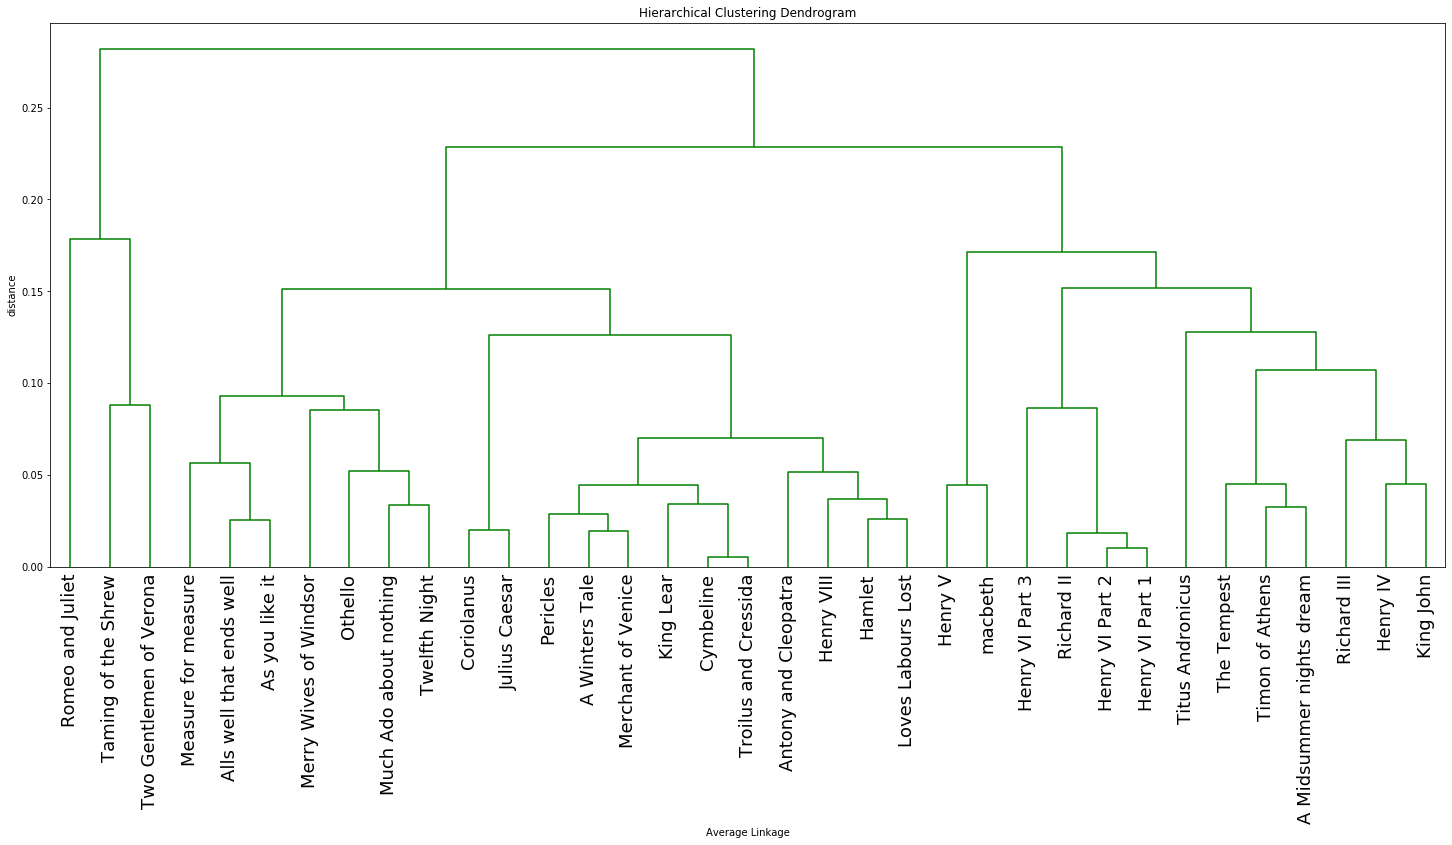

In [69]:
ncidata['ncilabs']=ncilabs  ##Labels for x axis
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Average Linkage')
plt.ylabel('distance')
dend = dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=18.,  # font size for the x axis labels
    labels= np.array(ncidata.ncilabs), #Labels for x axis
    color_threshold = 125, #np.inf, #What's 125 ? It is dist. on y axis, cutting the dendrogram horizontally giving 3 clusters 
    #p=64
)
plt.axhline(y=125, c='k' , linestyle='--')  # Notice the 3 clusters
plt.show()

In [70]:
cutree = cut_tree(Z, n_clusters=[3]).flatten()
cutree

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1])

In [71]:
#Getting labels for each of the clusters
clusters = {}
nclusters=3
for i in range(nclusters):
    c1 = np.argwhere(cutree==i).flatten()
    clusters[i] = list(ncilabs[c1])
    print("\nCluster: ",i," ",list(ncilabs[c1])) 
    print(c1)
clusters[nclusters] = ['A Comedy of Errors']


Cluster:  0   ['Hamlet', 'Coriolanus', 'Cymbeline', 'Antony and Cleopatra', 'King Lear', 'Othello', 'Troilus and Cressida', 'A Winters Tale', 'Henry VIII', 'Alls well that ends well', 'Measure for measure', 'Loves Labours Lost', 'Merry Wives of Windsor', 'As you like it', 'Merchant of Venice', 'Julius Caesar', 'Much Ado about nothing', 'Twelfth Night', 'Pericles']
[ 0  1  2  4  5  6  7  8  9 15 16 17 20 21 23 24 27 29 30]

Cluster:  1   ['Richard III', 'Henry V', 'Henry VI Part 2', 'Henry IV', 'Henry VI Part 3', 'Henry VI Part 1', 'Richard II', 'King John', 'Titus Andronicus', 'Timon of Athens', 'macbeth', 'The Tempest', 'A Midsummer nights dream']
[ 3 10 11 13 14 18 19 25 26 28 31 32 34]

Cluster:  2   ['Romeo and Juliet', 'Taming of the Shrew', 'Two Gentlemen of Verona']
[12 22 33]


As we can see from the dendogram above, these results suggest a similar approch to the one suggested by K-Means.Considering the coulier as a cluster itself, Both clustering techniques suggest there are between three and fout clusters. 
We will try to see it there is any chronological pattern associated with each cluster. Chances are that there are not, since the plays were written within a realtive short period of time. We will the perform LDA to each cluster to check whether clusters share topics and words. This will allow us to realize if writing style or choice of words vary among clusters. Should this be the case, this will be an indication that Shakespeare was actually a team of playwrights or the joint effort of some collaborations.

## Chronological analysis – did his writing traceably develop or evolve over time?

Tanking into consideration the clutering results, we will explore if there is any chronological change over time. As we will see below, the fact that the plays are numerous and that they were written during a short period of time suggests they could have been written by a group of people

In [72]:
#Clusters dictionary
list(clusters.keys())

[0, 1, 2, 3]

In [73]:
# Source Wikipedia
publish_years = [['Hamlet',1603],['Coriolanus', 1605],['Cymbeline', 1623],['Richard III', 1597],['Antony and Cleopatra',1606],
 ['King Lear',1605],['Othello',1603],['Troilus and Cressida', 1602],['A Winters Tale',1610],['Henry VIII',1613],
 ['Henry V',1599] , ['Henry VI Part 2',1591],['Romeo and Juliet',1595],['Henry IV',1597] ,[ 'Henry VI Part 3',1591],
  ['Alls well that ends well',1598],['Measure for measure', 1603],['Loves Labours Lost',1588],['Henry VI Part 1',1591],
['Richard II',1595],['Merry Wives of Windsor',1597],['As you like it',1599],['Taming of the Shrew',1592],
['Merchant of Venice',1596] ,['Julius Caesar',1599],['King John',1596],['Titus Andronicus', 1588],
['Much Ado about nothing', 1598],['Timon of Athens',1605],[ 'Twelfth Night', 1601],['Pericles',1606],['macbeth',1606],
['The Tempest',1610],['Two Gentlemen of Verona',1598],['A Midsummer nights dream',1595],[ 'A Comedy of Errors',1589]]

In [74]:
publish_years_df = pd.DataFrame(publish_years,columns = ['Play','Year'])
publish_years_df.sort_values(by=['Play'],inplace = True)

In [75]:
publish_years_df.head()

Play  Year
35        A Comedy of Errors  1589
34  A Midsummer nights dream  1595
8             A Winters Tale  1610
15  Alls well that ends well  1598
4       Antony and Cleopatra  1606

In [76]:
dict_publish_years = {}
for i in range(0,len(publish_years)):
    dict_publish_years[publish_years[i][0]] = publish_years[i][1]    
dict_publish_years.keys()

dict_keys(['Hamlet', 'Coriolanus', 'Cymbeline', 'Richard III', 'Antony and Cleopatra', 'King Lear', 'Othello', 'Troilus and Cressida', 'A Winters Tale', 'Henry VIII', 'Henry V', 'Henry VI Part 2', 'Romeo and Juliet', 'Henry IV', 'Henry VI Part 3', 'Alls well that ends well', 'Measure for measure', 'Loves Labours Lost', 'Henry VI Part 1', 'Richard II', 'Merry Wives of Windsor', 'As you like it', 'Taming of the Shrew', 'Merchant of Venice', 'Julius Caesar', 'King John', 'Titus Andronicus', 'Much Ado about nothing', 'Timon of Athens', 'Twelfth Night', 'Pericles', 'macbeth', 'The Tempest', 'Two Gentlemen of Verona', 'A Midsummer nights dream', 'A Comedy of Errors'])

In [77]:
name_cluster_year = []
for i in list(clusters.keys()):
#     print('##### Cluster:',i , '#######')
    for j in clusters[i]: 
        name_cluster_year.append([j,dict_publish_years[j],i])
#         print(j,dict_publish_years[j],i)   

In [78]:
name_cluster_year_df = pd.DataFrame(name_cluster_year, columns = ['Play','Year','Cluster'])
name_cluster_year_df.set_index('Play',inplace = True)
name_cluster_year_df.head()

Year  Cluster
Play                               
Hamlet                1603        0
Coriolanus            1605        0
Cymbeline             1623        0
Antony and Cleopatra  1606        0
King Lear             1605        0

In [79]:
PCA_df.set_index('Play',inplace = True)
PCA_df.head()

PC1       PC2       PC3       PC4
Play                                                        
Hamlet               -0.025997 -0.044910 -0.046079 -0.050574
Coriolanus            0.030237 -0.088709 -0.163317 -0.010725
Cymbeline             0.007839 -0.047084 -0.022219 -0.022262
Richard III          -0.109786  0.034548  0.044307 -0.022477
Antony and Cleopatra  0.006807 -0.052786 -0.110104  0.167461

In [80]:
df_year_cluster = PCA_df.join(name_cluster_year_df)
df_year_cluster.head()

PC1       PC2       PC3       PC4  Year  Cluster
Play                                                                       
Hamlet               -0.025997 -0.044910 -0.046079 -0.050574  1603        0
Coriolanus            0.030237 -0.088709 -0.163317 -0.010725  1605        0
Cymbeline             0.007839 -0.047084 -0.022219 -0.022262  1623        0
Richard III          -0.109786  0.034548  0.044307 -0.022477  1597        1
Antony and Cleopatra  0.006807 -0.052786 -0.110104  0.167461  1606        0

As we can see from the plot below, clusters there seems to be almost no bond between clusters and the years in which the plays were written.

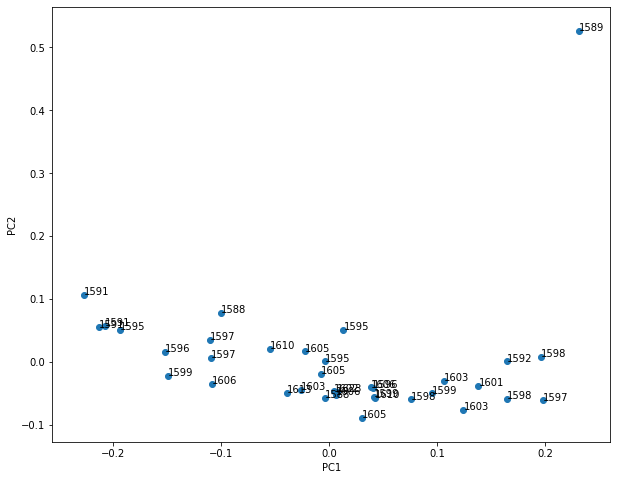

In [81]:
y = df_year_cluster.PC2
z = df_year_cluster.PC1
n = df_year_cluster.Year


fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(z, y)

plt.xlabel('PC1')
plt.ylabel('PC2');

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

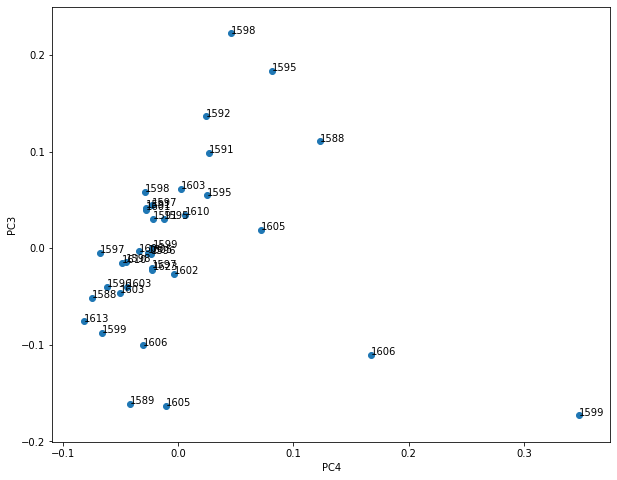

In [82]:
y = df_year_cluster.PC3
z = df_year_cluster.PC4
n = df_year_cluster.Year


fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(z, y)

plt.xlabel('PC4')
plt.ylabel('PC3');

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

We are now going to explore each of the clusters by using LDA. We will use this tool to try to find writing traceably developed or evolved in each of the clusters. We will try to discover words, writing styles or particula scenes or character. 

In [83]:
# from gensim import corpora, models
# from gensim.models.coherencemodel import CoherenceModel
# import pprint 
# import pyLDAvis
# import pyLDAvis.gensim  

In [84]:
def get_bag_words(plays_list):
    #Get Corpus
    corpus = []
    for j in plays_list:
        i = j
        play_names.append(i)
        play_df = df.loc[df['Play'] == i]
        play_df = play_df.dropna()
        all_text = play_df.PlayerLine.values
        documents = all_text
        document  = ' '.join(documents)
        corpus.append(document)
        
    # Convert all documents to lowercase
    doc_lower = [doc.lower() for doc in corpus] 
    
    # Tokenize
    tokenizer = RegexpTokenizer(r'[a-zA-Z]{2,}') 
    doc_tokens = [tokenizer.tokenize(doc) for doc in doc_lower]
    
    #Remove Stopwords
    # Get the set of stopwords to remove (include a few HTML tags)
    stops = set(stopwords.words("english"))
    stops = stops.union(['i','br'])

    # Strip stopwords from each document
    stopped_doc_tokens = []
    for doc in doc_tokens:
        stopped_doc_tokens.append([word for word in doc if not word in stops])
    
    # Use the Porter stemmer to strip words down to their roots
    stopstem_doc_tokens = []
    for doc in stopped_doc_tokens:
        stopstem_doc_tokens.append([PorterStemmer().stem(word) for word in doc])
    
    # Create a dictionary from our documents
    dictionary = corpora.Dictionary(stopstem_doc_tokens)
    
    # Convert the documents to the bag of words format
    corpus = [dictionary.doc2bow(doc) for doc in stopstem_doc_tokens]
    
    return corpus ,dictionary,stopstem_doc_tokens

In [85]:
df = pd.read_csv('./shakespeare-plays/Shakespeare_data.csv')

### Optimize LDA

In [86]:
def find_num_topics_lda(corpus,dicti,stopstem_doc_tokens):
    random_state = 100
    num_topics_lda = []
    for i in range(1,15,2):
        # Compute LDA
        lda = models.ldamodel.LdaModel(corpus, num_topics=i,
                                       id2word = dicti, passes=20,random_state = random_state)
        # perplexity
        perplexity = lda.log_perplexity(corpus)

        # coherence score
        coherence_model = CoherenceModel(model=lda, texts=stopstem_doc_tokens,
                                         dictionary=dicti, coherence='c_v')
        coherence = coherence_model.get_coherence()
       
        num_topics_lda.append([i,perplexity,coherence])
        print(i)
    return num_topics_lda

In [87]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


# Cluster # 1

In [88]:
i = 0
plays_list = clusters[i]
len(plays_list)

corpus , dictionary ,stopstem_doc_tokens= get_bag_words(plays_list)

In [89]:
# Compute_coherence_values to pick the best model
num_topics_lda = find_num_topics_lda(corpus,dictionary,stopstem_doc_tokens)
num_topics_lda

num_topics = list(map(lambda j :j[0],num_topics_lda))
perplexity_rest = list(map(lambda j :j[1],num_topics_lda))
coherence_rest = list(map(lambda j :j[2],num_topics_lda))


1
3
5
7
9
11
13


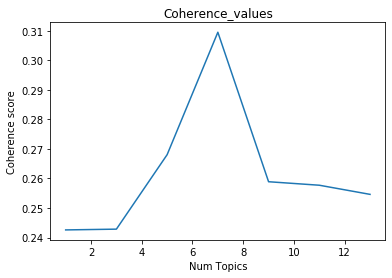

In [92]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(num_topics, coherence_rest)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title(("Coherence_values"))
plt.show()

In [93]:
# Compute LDA
random_state = 5
lda = models.ldamodel.LdaModel(corpus, num_topics=7, id2word = dictionary, passes=20,random_state = random_state)

# Use print_topics method to summarize the results by # topics and # words per topic
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_topics=7, num_words=20))


# # Show Topics
# for t_num, words in lda_rest.show_topics(formatted=False):
#     print("Topic number {}:".format(t_num))
#     for word, score in words:
#         print(word, score)
#     print()


[   (   0,
        '0.000*"thou" + 0.000*"lord" + 0.000*"let" + 0.000*"love" + '
        '0.000*"shall" + 0.000*"thee" + 0.000*"good" + 0.000*"thi" + '
        '0.000*"man" + 0.000*"sir" + 0.000*"come" + 0.000*"see" + 0.000*"know" '
        '+ 0.000*"would" + 0.000*"well" + 0.000*"must" + 0.000*"may" + '
        '0.000*"hath" + 0.000*"one" + 0.000*"ti"'),
    (   1,
        '0.009*"thou" + 0.009*"shall" + 0.008*"lord" + 0.008*"good" + '
        '0.007*"come" + 0.007*"sir" + 0.007*"thi" + 0.006*"would" + '
        '0.006*"one" + 0.006*"let" + 0.006*"make" + 0.006*"know" + '
        '0.005*"well" + 0.005*"love" + 0.005*"thee" + 0.005*"say" + '
        '0.005*"like" + 0.005*"us" + 0.005*"king" + 0.004*"may"'),
    (   2,
        '0.000*"thou" + 0.000*"sir" + 0.000*"love" + 0.000*"lord" + '
        '0.000*"come" + 0.000*"shall" + 0.000*"good" + 0.000*"thi" + '
        '0.000*"would" + 0.000*"know" + 0.000*"well" + 0.000*"let" + '
        '0.000*"thee" + 0.000*"go" + 0.000*"ti" + 0.000*"man

In [94]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

/Users/marianegri/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.178235 -0.024590       1        1  55.056423
4     -0.188058 -0.039839       2        1  27.592405
3     -0.187486  0.063808       3        1  17.346113
5      0.136199 -0.000561       4        1   0.001264
2      0.138778  0.000098       5        1   0.001264
0      0.139302  0.000145       6        1   0.001264
6      0.139501  0.000938       7        1   0.001264, topic_info=     Category         Freq    Term        Total  loglift  logprob
407   Default   383.000000  caesar   383.000000  30.0000  30.0000
3014  Default  2242.000000    thou  2242.000000  29.0000  29.0000
555   Default  1834.000000    come  1834.000000  28.0000  28.0000
2644  Default  1893.000000   shall  1893.000000  27.0000  27.0000
2710  Default  1628.000000     sir  1628.000000  26.0000  26.0000
...       ...          ...     ...          ...      ...      ...
3437   Topic7     0.000313     yet   862.686707  -3.5511  -9.0689
1396   Topic7     0.000306    hear   575.357849  -3.1681  -9.0910
1285   Topic7     0.000306     god   571.030151  -3.1608  -9.0913
2047   Topic7     0.000311     one  1089.136963  -3.7921  -9.0769
3007   Topic7     0.000307   think   716.019348  -3.3831  -9.0873

[594 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         1  0.985157     aboard
7155      2  0.995168      achil
7162      2  0.980399  agamemnon
4668      1  0.052692       ajax
4668      2  0.948463       ajax
...     ...       ...        ...
3430      2  0.167859         ye
3430      3  0.124216         ye
3437      1  0.547128        yet
3437      2  0.288633        yet
3437      3  0.164602        yet

[468 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 6, 3, 1, 7])

In [95]:
lda = models.ldamodel.LdaModel(corpus, num_topics=7, id2word = dictionary, passes=20,random_state = random_state)

df_topic_sents_keywords = format_topics_sentences(lda, corpus, stopstem_doc_tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             1.0              0.9110   
1            1             1.0              0.9992   
2            2             1.0              0.9970   
3            3             3.0              0.6496   
4            4             4.0              0.6102   

                                            Keywords  \
0  thou, shall, lord, good, come, sir, thi, would...   
1  thou, shall, lord, good, come, sir, thi, would...   
2  thou, shall, lord, good, come, sir, thi, would...   
3  shall, come, thou, sir, caesar, good, let, wel...   
4  thou, come, love, thi, thee, good, shall, man,...   

                                                Text  
0  [nay, answer, stand, unfold, long, live, king,...  
1  [proceed, hear, speak, speak, speak, resolv, r...  
2  [meet, man, frown, blood, obey, heaven, courti...  
3  [nay, dotag, gener, erflow, measur, goodli, ey...  
4  [thought, king, affect, duke, albani, cornwal,...

# Cluster # 2

In [96]:
i = 1
plays_list = clusters[i]
len(plays_list)

corpus , dictionary ,stopstem_doc_tokens= get_bag_words(plays_list)

1
3
5
7
9
11
13
[1, 3, 5, 7, 9, 11, 13]
[-7.682719799821631, -7.666513769737797, -7.684776280818181, -7.6969268041832954, -7.698655120158697, -7.72648090609509, -7.73211771380612]
[0.23842115854873575, 0.24634138110783646, 0.26040534694428896, 0.2517188338426391, 0.24736817376513523, 0.24284685077328677, 0.25463408320251374]


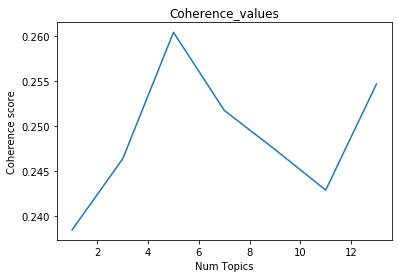

In [97]:
# Compute_coherence_values to pick the best model
num_topics_lda = find_num_topics_lda(corpus,dictionary,stopstem_doc_tokens)
num_topics_lda

num_topics = list(map(lambda j :j[0],num_topics_lda))
perplexity_test = list(map(lambda j :j[1],num_topics_lda))
coherence_test = list(map(lambda j :j[2],num_topics_lda))
                          
print(num_topics)
print(perplexity_test)
print(coherence_test)


# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(num_topics, coherence_test)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title(("Coherence_values"))
plt.show()

In [98]:
# Compute LDA
random_stat = 5
lda = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20,random_state = random_state)

# Use print_topics method to summarize the results by # topics and # words per topic
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_topics=5, num_words=15))

[   (   0,
        '0.010*"thou" + 0.009*"shall" + 0.008*"thi" + 0.007*"king" + '
        '0.007*"franc" + 0.006*"lord" + 0.006*"thee" + 0.005*"us" + '
        '0.005*"good" + 0.005*"let" + 0.005*"like" + 0.004*"hath" + '
        '0.004*"upon" + 0.004*"come" + 0.004*"may"'),
    (   1,
        '0.017*"thou" + 0.015*"thi" + 0.012*"lord" + 0.011*"thee" + '
        '0.007*"let" + 0.006*"come" + 0.006*"shall" + 0.005*"good" + '
        '0.005*"man" + 0.005*"would" + 0.005*"make" + 0.005*"rome" + '
        '0.005*"timon" + 0.005*"like" + 0.004*"know"'),
    (   2,
        '0.000*"thou" + 0.000*"thee" + 0.000*"lord" + 0.000*"shall" + '
        '0.000*"thi" + 0.000*"come" + 0.000*"good" + 0.000*"man" + '
        '0.000*"love" + 0.000*"upon" + 0.000*"would" + 0.000*"make" + '
        '0.000*"yet" + 0.000*"king" + 0.000*"let"'),
    (   3,
        '0.017*"thou" + 0.014*"thi" + 0.012*"lord" + 0.010*"king" + '
        '0.009*"shall" + 0.009*"thee" + 0.006*"come" + 0.005*"let" + '
        '0.005*"

In [99]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

/Users/marianegri/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.088023 -0.025222       1        1  46.956230
4      0.042885  0.040551       2        1  19.962828
0      0.033449 -0.069084       3        1  19.196831
1      0.060178  0.052199       4        1  13.882309
2     -0.224535  0.001556       5        1   0.001803, topic_info=     Category         Freq   Term        Total  loglift  logprob
1017  Default   284.000000  franc   284.000000  30.0000  30.0000
2542  Default  2201.000000   thou  2201.000000  29.0000  29.0000
2533  Default  1707.000000    thi  1707.000000  28.0000  28.0000
2524  Default  1219.000000   thee  1219.000000  27.0000  27.0000
1497  Default  1334.000000   lord  1334.000000  26.0000  26.0000
...       ...          ...    ...          ...      ...      ...
2562   Topic5     0.000330     ti   353.855682  -2.9631  -8.9743
2256   Topic5     0.000327    sir   335.275482  -2.9161  -8.9812
1561   Topic5     0.000331    may   514.971130  -3.3339  -8.9699
605    Topic5     0.000328    day   480.088409  -3.2733  -8.9794
1076   Topic5     0.000327    god   524.309021  -3.3638  -8.9818

[427 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7799      4  0.986794     aaron
66        1  0.964386     alban
8126      4  0.968183  alcibiad
2974      1  0.064780   alencon
2974      3  0.906917   alencon
...     ...       ...       ...
2919      2  0.238227       yet
2919      3  0.155366       yet
2919      4  0.105649       yet
2925      1  0.936768      york
2925      3  0.062133      york

[587 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])

In [100]:
df_topic_sents_keywords = format_topics_sentences(lda, corpus, stopstem_doc_tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.7426   
1            1             0.0              0.9989   
2            2             3.0              0.9997   
3            3             3.0              0.9994   
4            4             3.0              0.9999   

                                            Keywords  \
0  thou, thi, lord, king, shall, thee, come, let,...   
1  thou, shall, thi, king, franc, lord, thee, us,...   
2  thou, thi, lord, king, shall, thee, come, let,...   
3  thou, thi, lord, king, shall, thee, come, let,...   
4  thou, thi, lord, king, shall, thee, come, let,...   

                                                Text  
0  [winter, discont, made, gloriou, summer, sun, ...  
1  [act, prologu, muse, fire, would, ascend, brig...  
2  [high, imperi, majesti, charg, depart, franc, ...  
3  [shaken, wan, care, find, time, fright, peac, ...  
4  [wonder, king, escap, hand, pursu, horsemen, n...

# Cluster # 3

In [101]:
i = 2
plays_list = clusters[i]
len(plays_list)

corpus , dictionary ,stopstem_doc_tokens= get_bag_words(plays_list)

1
3
5
7
9
11
13
[1, 3, 5, 7, 9, 11, 13]
[-7.3964574401247845, -7.371311331347802, -7.394300542641661, -7.39955500135383, -7.4453174495139125, -7.501695986791282, -7.519049557595283]
[0.2328792585112592, 0.23841537868463777, 0.23846045252607162, 0.2514506934189676, 0.23767927074360917, 0.23672093309177694, 0.23398289806708267]


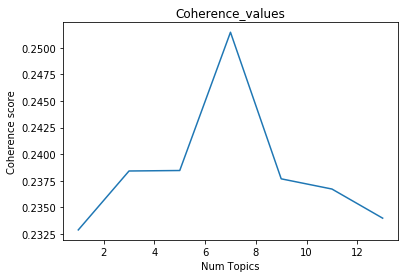

In [102]:
# Compute_coherence_values to pick the best model
num_topics_lda = find_num_topics_lda(corpus,dictionary,stopstem_doc_tokens)
num_topics_lda

num_topics = list(map(lambda j :j[0],num_topics_lda))
perplexity_test = list(map(lambda j :j[1],num_topics_lda))
coherence_test = list(map(lambda j :j[2],num_topics_lda))
                          
print(num_topics)
print(perplexity_test)
print(coherence_test)


# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(num_topics, coherence_test)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title(("Coherence_values"))
plt.show()

In [103]:
# Compute LDA
random_stat = 5
lda = models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20,random_state = random_state)

# Use print_topics method to summarize the results by # topics and # words per topic
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_topics=5, num_words=30))

[   (   0,
        '0.000*"thou" + 0.000*"sir" + 0.000*"love" + 0.000*"thi" + '
        '0.000*"come" + 0.000*"shall" + 0.000*"thee" + 0.000*"go" + '
        '0.000*"say" + 0.000*"well" + 0.000*"would" + 0.000*"hath" + '
        '0.000*"know" + 0.000*"take" + 0.000*"good" + 0.000*"one" + '
        '0.000*"yet" + 0.000*"romeo" + 0.000*"make" + 0.000*"man" + '
        '0.000*"let" + 0.000*"master" + 0.000*"ti" + 0.000*"tell" + '
        '0.000*"look" + 0.000*"ay" + 0.000*"father" + 0.000*"sweet" + '
        '0.000*"mine" + 0.000*"much"'),
    (   1,
        '0.000*"thou" + 0.000*"love" + 0.000*"come" + 0.000*"thi" + '
        '0.000*"thee" + 0.000*"good" + 0.000*"shall" + 0.000*"sir" + '
        '0.000*"well" + 0.000*"say" + 0.000*"go" + 0.000*"may" + 0.000*"like" '
        '+ 0.000*"let" + 0.000*"see" + 0.000*"man" + 0.000*"one" + '
        '0.000*"hath" + 0.000*"make" + 0.000*"know" + 0.000*"romeo" + '
        '0.000*"master" + 0.000*"tell" + 0.000*"sweet" + 0.000*"must" + '
        '0

In [104]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

/Users/marianegri/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.129394  0.068817       1        1  67.261635
4      0.137088 -0.066470       2        1  32.732563
2     -0.087791 -0.001190       3        1   0.001936
1     -0.089261 -0.000541       4        1   0.001936
0     -0.089430 -0.000616       5        1   0.001936, topic_info=     Category        Freq      Term       Total  loglift  logprob
1932  Default  123.000000     romeo  123.000000  30.0000  30.0000
2095  Default  277.000000       sir  277.000000  29.0000  29.0000
3274  Default   60.000000      kate   60.000000  28.0000  28.0000
2476  Default   56.000000    tybalt   56.000000  27.0000  27.0000
2541  Default   56.000000  valentin   56.000000  26.0000  26.0000
...       ...         ...       ...         ...      ...      ...
145    Topic5    0.000141        ay  103.794899  -2.6580  -8.3582
833    Topic5    0.000141    father  112.843971  -2.7427  -8.3593
2294   Topic5    0.000141     sweet   91.280708  -2.5307  -8.3594
1462   Topic5    0.000141      mine   80.921043  -2.4105  -8.3596
1521   Topic5    0.000141      much   88.948303  -2.5059  -8.3604

[384 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2737      2  0.771851    abject
2738      2  0.771801     abjur
2744      2  0.771835   accoutr
2756      2  0.771884      ajax
2757      2  0.771853        al
...     ...       ...       ...
3856      2  0.771760     wrapp
2713      1  0.980314      writ
3858      2  0.771770  xanthipp
2724      1  0.740389       yet
2724      2  0.266884       yet

[305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 2, 1])

In [105]:
df_topic_sents_keywords = format_topics_sentences(lda, corpus, stopstem_doc_tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.9999   
1            1             4.0              0.9999   
2            2             3.0              0.9999   

                                            Keywords  \
0  thou, love, thi, thee, come, shall, sir, good,...   
1  sir, come, thou, shall, well, thi, good, thee,...   
2  thou, love, thi, thee, come, shall, sir, good,...   

                                                Text  
0  [two, household, alik, digniti, fair, verona, ...  
1  [pheez, faith, pair, stock, rogu, ye, baggag, ...  
2  [ceas, persuad, love, proteu, home, keep, yout...

# Cluster # 4

In [106]:
i = 3
plays_list = clusters[i]
len(plays_list)

corpus , dictionary ,stopstem_doc_tokens= get_bag_words(plays_list)

1
3
5
7
9
11
13
[1, 3, 5, 7, 9, 11, 13]
[-7.037274370373271, -7.100365872028828, -7.167282430863559, -7.221785200949286, -7.267066459502743, -7.305674529865504, -7.339305976759472]
[0.27881953670623916, 0.2769120923119372, 0.2780233065743384, 0.28111235240684757, 0.28636117972286423, 0.2895136574418968, 0.28948303578510287]


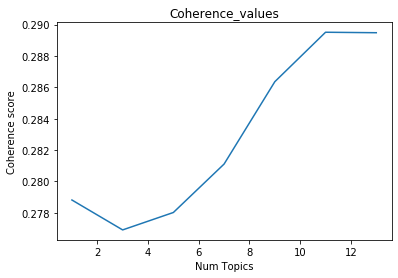

In [107]:
# Compute_coherence_values to pick the best model
num_topics_lda = find_num_topics_lda(corpus,dictionary,stopstem_doc_tokens)
num_topics_lda

num_topics = list(map(lambda j :j[0],num_topics_lda))
perplexity_test = list(map(lambda j :j[1],num_topics_lda))
coherence_test = list(map(lambda j :j[2],num_topics_lda))
                          
print(num_topics)
print(perplexity_test)
print(coherence_test)


# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(num_topics, coherence_test)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title(("Coherence_values"))
plt.show()

In [108]:
# Compute LDA
random_stat = 5
lda = models.ldamodel.LdaModel(corpus, num_topics=7, id2word = dictionary, passes=20,random_state = random_state)

# Use print_topics method to summarize the results by # topics and # words per topic
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda.print_topics(num_topics=7, num_words=15))

[   (   0,
        '0.001*"antipholu" + 0.001*"thou" + 0.001*"sir" + 0.001*"come" + '
        '0.001*"thee" + 0.001*"go" + 0.001*"man" + 0.001*"chain" + 0.001*"thi" '
        '+ 0.001*"master" + 0.001*"know" + 0.001*"home" + 0.001*"say" + '
        '0.001*"one" + 0.001*"dromio"'),
    (   1,
        '0.001*"antipholu" + 0.001*"thou" + 0.001*"come" + 0.001*"sir" + '
        '0.001*"chain" + 0.001*"thi" + 0.001*"thee" + 0.001*"master" + '
        '0.001*"man" + 0.001*"know" + 0.001*"go" + 0.001*"time" + 0.001*"make" '
        '+ 0.001*"see" + 0.001*"hath"'),
    (   2,
        '0.025*"antipholu" + 0.018*"thou" + 0.015*"sir" + 0.009*"come" + '
        '0.009*"thee" + 0.008*"thi" + 0.008*"man" + 0.007*"know" + '
        '0.007*"master" + 0.006*"go" + 0.006*"chain" + 0.006*"would" + '
        '0.006*"home" + 0.005*"us" + 0.005*"time"'),
    (   3,
        '0.001*"antipholu" + 0.001*"thou" + 0.001*"sir" + 0.001*"thi" + '
        '0.001*"master" + 0.001*"come" + 0.001*"know" + 0.001*"thee" + 

In [109]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

/Users/marianegri/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
2     -0.124528  0.0       1        1  99.988106
6      0.018866 -0.0       2        1   0.001981
3      0.019526  0.0       3        1   0.001981
0      0.021655  0.0       4        1   0.001981
1      0.021226 -0.0       5        1   0.001981
5      0.021621 -0.0       6        1   0.001981
4      0.021635  0.0       7        1   0.001981, topic_info=     Category        Freq       Term       Total  loglift  logprob
64    Default  182.000000  antipholu  182.000000  30.0000  30.0000
1699  Default  129.000000       thou  129.000000  29.0000  29.0000
1507  Default  107.000000        sir  107.000000  28.0000  28.0000
1683  Default   62.000000       thee   62.000000  27.0000  27.0000
289   Default   62.000000       come   62.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
1013   Topic7    0.000074       make   30.959969  -2.1090  -7.5601
1717   Topic7    0.000074       time   36.740932  -2.2803  -7.5601
851    Topic7    0.000074       hous   26.146435  -1.9401  -7.5602
1882   Topic7    0.000074       wife   33.854435  -2.1985  -7.5602
1163   Topic7    0.000074        one   34.815662  -2.2266  -7.5603

[534 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         1  0.908913       abet
4         1  0.909015     abject
30        1  0.908912  afternoon
31        1  0.909049  afterward
39        1  0.908939     albeit
...     ...       ...        ...
1882      1  1.004300       wife
1890      1  0.909168       wink
1893      1  0.908888       wise
1899      1  0.998795     within
1918      1  0.988858      would

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 1, 2, 6, 5])

In [110]:
df_topic_sents_keywords = format_topics_sentences(lda, corpus, stopstem_doc_tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.9999   

                                            Keywords  \
0  antipholu, thou, sir, come, thee, thi, man, kn...   

                                                Text  
0  [proceed, solinu, procur, fall, doom, death, e...